# Automatic Weather Station Analysis System

This notebook implements a comprehensive analysis system for weather station data, focusing on rainfall, temperature, humidity, and wind measurements. The system provides detailed insights into weather patterns and includes alert mechanisms for extreme conditions.

## System Components
1. Data Collection and Management
2. Weather Parameter Analysis
3. Time Series Visualization
4. Pattern Recognition
5. Alert System

## Data Fields
- **timestamp**: Date and time of measurement
- **rainfall_intensity**: Rainfall intensity (mm/hr)
- **cumulative_rainfall**: Total accumulated rainfall (mm)
- **rainfall_duration**: Duration of rainfall event (hours)
- **temperature**: Air temperature (°C)
- **humidity**: Relative humidity (%)
- **wind_speed**: Wind speed (m/s)

## 📁 Directory Structure

This notebook uses the following directory structure:

### Input Directories:
- **Data**: `AI ROCKFALL PREDICTION/Data/`
  - Contains or will contain: `weather_station_data.csv`
  - If data doesn't exist, it will be generated automatically
  
- **Images**: `AI ROCKFALL PREDICTION/Upload/Auto_Weather_station/images/`
  - Source directory for device images
  - Used for image processing and analysis

### Output Directories:
- **Analysis**: `AI ROCKFALL PREDICTION/Upload/Auto_Weather_station/Analysis/`
  - Prediction results exported as CSV: `weather_predictions.csv`
  - JSON analysis report: `weather_analysis_report.json`
  
- **Report**: `AI ROCKFALL PREDICTION/Upload/Auto_Weather_station/Report/`
  - Final comprehensive PDF report: `weather_analysis_report.pdf`

---

## 1. Setup and Required Libraries

Import necessary libraries and set up the environment for weather data processing and analysis.

In [16]:
# Import required libraries
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define base directories
BASE_DIR = r'c:\Users\rkste\Desktop\AI Rockfall Prediction'
DATA_DIR = os.path.join(BASE_DIR, 'Data')
UPLOAD_DIR = os.path.join(BASE_DIR, 'Upload', 'Auto_Weather_station')
IMAGES_DIR = os.path.join(UPLOAD_DIR, 'images')
ANALYSIS_DIR = os.path.join(UPLOAD_DIR, 'Analysis')
REPORT_DIR = os.path.join(UPLOAD_DIR, 'Report')

# Create necessary directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(ANALYSIS_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

# Helper function to get next available filename (non-overwrite)
def get_next_filename(directory, base_name, extension):
    """
    Get the next available filename without overwriting existing files.
    Examples:
        data.csv -> data_1.csv, data_2.csv, etc.
        dashboard.json -> dashboard_1.json, dashboard_2.json, etc.
    """
    # Check if base file exists
    base_path = os.path.join(directory, f"{base_name}{extension}")
    if not os.path.exists(base_path):
        return base_path
    
    # Find all numbered versions
    pattern = os.path.join(directory, f"{base_name}_*{extension}")
    existing_files = glob.glob(pattern)
    
    if not existing_files:
        return os.path.join(directory, f"{base_name}_1{extension}")
    
    # Extract numbers from existing files
    numbers = []
    for filepath in existing_files:
        filename = os.path.basename(filepath)
        match = re.search(rf"{re.escape(base_name)}_(\d+){re.escape(extension)}", filename)
        if match:
            numbers.append(int(match.group(1)))
    
    # Get next number
    next_num = max(numbers) + 1 if numbers else 1
    return os.path.join(directory, f"{base_name}_{next_num}{extension}")

# Define file paths (will be updated with non-overwrite logic when saving)
DATA_FILE = os.path.join(DATA_DIR, 'weather_station_data.csv')
PREDICTION_OUTPUT = os.path.join(ANALYSIS_DIR, 'weather_predictions.csv')
REPORT_PDF = os.path.join(REPORT_DIR, 'weather_analysis_report.pdf')

print("✓ Libraries imported successfully")
print("✓ Directories verified/created:")
print(f"  - Data Directory: {DATA_DIR}")
print(f"  - Images Directory: {IMAGES_DIR}")
print(f"  - Analysis Directory: {ANALYSIS_DIR}")
print(f"  - Report Directory: {REPORT_DIR}")
print("✓ Non-overwrite file system initialized")
print("✓ System initialized")

✓ Libraries imported successfully
✓ Directories verified/created:
  - Data Directory: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data
  - Images Directory: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Auto_Weather_station\images
  - Analysis Directory: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Auto_Weather_station\Analysis
  - Report Directory: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Auto_Weather_station\Report
✓ Non-overwrite file system initialized
✓ System initialized


## 2. Data Generation and Management

Create synthetic weather station data with realistic patterns or load existing data. The system simulates hourly readings with realistic weather patterns.

In [2]:
def generate_weather_data(n_samples=168):  # Default to 7 days of hourly data
    """
    Generate synthetic weather station data with realistic patterns.
    Creates hourly readings with seasonal and daily patterns.
    """
    data = {
        'timestamp': [],
        'rainfall_intensity': [],
        'cumulative_rainfall': [],
        'rainfall_duration': [],
        'temperature': [],
        'humidity': [],
        'wind_speed': []
    }
    
    # Generate timestamps (hourly readings)
    end_date = datetime.now()
    start_date = end_date - timedelta(hours=n_samples)
    timestamps = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Base parameters
    base_temp = 25  # Base temperature in celsius
    base_humidity = 60  # Base humidity percentage
    base_wind = 5  # Base wind speed in m/s
    
    cumulative_rain = 0
    current_rain_duration = 0
    rain_event = False
    
    for i in range(n_samples):
        timestamp = timestamps[i]
        hour = timestamp.hour
        day = timestamp.day
        
        # Temperature with daily and random variation
        temp_variation = 5 * np.sin(2 * np.pi * hour / 24)  # Daily cycle
        temp_noise = np.random.normal(0, 2)
        temperature = base_temp + temp_variation + temp_noise
        
        # Humidity inverse to temperature
        humidity_variation = -3 * np.sin(2 * np.pi * hour / 24)
        humidity_noise = np.random.normal(0, 5)
        humidity = base_humidity + humidity_variation + humidity_noise
        humidity = np.clip(humidity, 30, 100)
        
        # Wind speed with daily pattern
        wind_variation = 2 * np.sin(2 * np.pi * hour / 24)
        wind_noise = np.random.normal(0, 1)
        wind_speed = max(0, base_wind + wind_variation + wind_noise)
        
        # Rainfall simulation
        if not rain_event and np.random.random() < 0.1:  # 10% chance of rain starting
            rain_event = True
            current_rain_duration = 0
        elif rain_event and np.random.random() < 0.3:  # 30% chance of rain stopping
            rain_event = False
        
        if rain_event:
            current_rain_duration += 1
            rainfall_intensity = max(0, np.random.normal(5, 2))
            cumulative_rain += rainfall_intensity
        else:
            rainfall_intensity = 0
            current_rain_duration = 0
        
        # Store values
        data['timestamp'].append(timestamp)
        data['rainfall_intensity'].append(rainfall_intensity)
        data['cumulative_rainfall'].append(cumulative_rain)
        data['rainfall_duration'].append(current_rain_duration)
        data['temperature'].append(temperature)
        data['humidity'].append(humidity)
        data['wind_speed'].append(wind_speed)
    
    return pd.DataFrame(data)

def load_or_create_weather_data():
    """
    Load existing weather data or create new synthetic data if file doesn't exist.
    Checks in AI ROCKFALL PREDICTION/Data/ directory.
    """
    if os.path.exists(DATA_FILE):
        print(f"✓ Data file found: {DATA_FILE}")
        existing_data = pd.read_csv(DATA_FILE)
        existing_data['timestamp'] = pd.to_datetime(existing_data['timestamp'])
        print(f"✓ Loaded existing data: {len(existing_data)} records")
        return existing_data
    else:
        print(f"⚠ Data file not found. Generating new data...")
        new_data = generate_weather_data()
        new_data.to_csv(DATA_FILE, index=False)
        print(f"✓ Generated and saved new data: {len(new_data)} records")
        print(f"✓ Data saved to: {DATA_FILE}")
        return new_data

# Load or generate initial data
df = load_or_create_weather_data()
print(f"\n{'='*60}")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Data columns: {df.columns.tolist()}")
print(f"{'='*60}\n")
df.head()

✓ Data file found: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data\weather_station_data.csv
✓ Loaded existing data: 168 records

Dataset shape: (168, 7)
Date range: 2025-10-18 16:37:34.516571 to 2025-10-25 15:37:34.516571
Data columns: ['timestamp', 'rainfall_intensity', 'cumulative_rainfall', 'rainfall_duration', 'temperature', 'humidity', 'wind_speed']



,timestamp,rainfall_intensity,cumulative_rainfall,rainfall_duration,temperature,humidity,wind_speed
0,2025-10-18 16:37:34.516571,0.0,0.0,0,21.663301,61.906755,3.915638
1,2025-10-18 17:37:34.516571,0.0,0.0,0,23.216431,64.292984,4.078664
2,2025-10-18 18:37:34.516571,0.0,0.0,0,19.061051,65.712800,2.536582
3,2025-10-18 19:37:34.516571,0.0,0.0,0,19.238911,49.835032,4.018518
4,2025-10-18 20:37:34.516571,0.0,0.0,0,18.644211,64.169313,2.359925


## 2.1 Image Processing from Device Images

Process weather station device images from the Upload/Auto_Weather_station/images/ directory.

In [17]:
# Image Processing from Device Images Directory
from PIL import Image
import glob

def process_weather_station_images():
    """
    Process weather station device images from the images directory.
    Scans for common image formats and provides analysis capabilities.
    """
    # Check for images in the directory
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    all_images = []
    
    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(IMAGES_DIR, ext)))
        all_images.extend(glob.glob(os.path.join(IMAGES_DIR, ext.upper())))
    
    if len(all_images) == 0:
        print("⚠ No images found in the images directory")
        print(f"  Directory: {IMAGES_DIR}")
        print("  Supported formats: JPG, JPEG, PNG, BMP, TIFF")
        return None
    
    print(f"✓ Found {len(all_images)} image(s) in {IMAGES_DIR}")
    
    # Process each image
    image_data = []
    for idx, img_path in enumerate(all_images, 1):
        try:
            img = Image.open(img_path)
            img_info = {
                'filename': os.path.basename(img_path),
                'path': img_path,
                'format': img.format,
                'size': img.size,
                'mode': img.mode,
                'width': img.size[0],
                'height': img.size[1]
            }
            image_data.append(img_info)
            print(f"  [{idx}] {img_info['filename']}: {img_info['width']}x{img_info['height']} ({img_info['format']})")
        except Exception as e:
            print(f"  ✗ Error processing {os.path.basename(img_path)}: {str(e)}")
    
    return pd.DataFrame(image_data) if image_data else None

# Process images
print("=" * 80)
print("PROCESSING WEATHER STATION DEVICE IMAGES")
print("=" * 80)
images_df = process_weather_station_images()

if images_df is not None:
    print(f"\n✓ Successfully processed {len(images_df)} image(s)")
    print("\nImage Summary:")
    print(images_df[['filename', 'width', 'height', 'format']])
    
    # Visualize first few images if available
    if len(images_df) > 0:
        n_images = min(3, len(images_df))
        fig, axes = plt.subplots(1, n_images, figsize=(6*n_images, 6))
        if n_images == 1:
            axes = [axes]
        
        for idx in range(n_images):
            img = Image.open(images_df.iloc[idx]['path'])
            axes[idx].imshow(img)
            axes[idx].set_title(f"{images_df.iloc[idx]['filename']}\n{images_df.iloc[idx]['width']}x{images_df.iloc[idx]['height']}")
            axes[idx].axis('off')
        
        plt.suptitle('Weather Station Device Images (Sample)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("\n⚠ No images to process. Continuing with data analysis...")

print("=" * 80)

PROCESSING WEATHER STATION DEVICE IMAGES
⚠ No images found in the images directory
  Directory: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Auto_Weather_station\images
  Supported formats: JPG, JPEG, PNG, BMP, TIFF

⚠ No images to process. Continuing with data analysis...


## 3. Data Preprocessing and Feature Engineering

Prepare the weather data for analysis by handling missing values, creating derived features, and calculating weather indices.

In [18]:
def preprocess_weather_data(df):
    """
    Preprocess weather data and engineer new features.
    """
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Handle missing values
    numeric_columns = ['rainfall_intensity', 'cumulative_rainfall', 'rainfall_duration', 
                      'temperature', 'humidity', 'wind_speed']
    processed_df[numeric_columns] = processed_df[numeric_columns].fillna(
        processed_df[numeric_columns].mean()
    )
    
    # Add datetime components
    processed_df['hour'] = processed_df['timestamp'].dt.hour
    processed_df['day'] = processed_df['timestamp'].dt.day
    processed_df['month'] = processed_df['timestamp'].dt.month
    processed_df['season'] = (processed_df['month'] % 12 + 3) // 3
    
    # Calculate heat index (when temperature > 20°C and humidity > 40%)
    mask = (processed_df['temperature'] > 20) & (processed_df['humidity'] > 40)
    processed_df['heat_index'] = np.where(mask,
        -8.784695 + 1.61139411 * processed_df['temperature'] + 
        2.338549 * processed_df['humidity'] - 0.14611605 * processed_df['temperature'] * 
        processed_df['humidity'] - 0.012308094 * processed_df['temperature']**2 - 
        0.016424828 * processed_df['humidity']**2 + 0.002211732 * 
        processed_df['temperature']**2 * processed_df['humidity'] + 
        0.00072546 * processed_df['temperature'] * processed_df['humidity']**2 - 
        0.000003582 * processed_df['temperature']**2 * processed_df['humidity']**2,
        processed_df['temperature'])
    
    # Calculate hourly changes
    processed_df['temp_change'] = processed_df['temperature'].diff()
    processed_df['humidity_change'] = processed_df['humidity'].diff()
    processed_df['wind_speed_change'] = processed_df['wind_speed'].diff()
    
    # Calculate moving averages
    processed_df['temp_ma_24h'] = processed_df['temperature'].rolling(window=24).mean()
    processed_df['humidity_ma_24h'] = processed_df['humidity'].rolling(window=24).mean()
    processed_df['wind_speed_ma_24h'] = processed_df['wind_speed'].rolling(window=24).mean()
    
    # Calculate rain intensity categories
    processed_df['rain_intensity_category'] = pd.cut(
        processed_df['rainfall_intensity'],
        bins=[-np.inf, 0, 2.5, 7.5, 15, np.inf],
        labels=['None', 'Light', 'Moderate', 'Heavy', 'Extreme']
    )
    
    # Calculate weather comfort index (simplified)
    processed_df['comfort_index'] = (0.5 * processed_df['temperature'] + 
                                   0.3 * processed_df['humidity'] - 
                                   0.2 * processed_df['wind_speed'])
    
    # Handle any remaining missing values
    processed_df = processed_df.fillna(method='ffill').fillna(method='bfill')
    
    return processed_df

# Process the data
processed_df = preprocess_weather_data(df)
print("✓ Data preprocessing completed")
print(f"\nProcessed features: {len(processed_df.columns)} columns")
print("\nEngineered features:")
print("- Datetime components: hour, day, month, season")
print("- Weather indices: heat_index, comfort_index")
print("- Moving averages: 24-hour moving averages for temperature, humidity, and wind speed")
print("- Change rates: hourly changes in temperature, humidity, and wind speed")
print("- Categories: rain_intensity_category")

processed_df.head()

✓ Data preprocessing completed

Processed features: 20 columns

Engineered features:
- Datetime components: hour, day, month, season
- Weather indices: heat_index, comfort_index
- Moving averages: 24-hour moving averages for temperature, humidity, and wind speed
- Change rates: hourly changes in temperature, humidity, and wind speed
- Categories: rain_intensity_category


,timestamp,rainfall_intensity,cumulative_rainfall,rainfall_duration,temperature,humidity,wind_speed,hour,day,month,season,heat_index,temp_change,humidity_change,wind_speed_change,temp_ma_24h,humidity_ma_24h,wind_speed_ma_24h,rain_intensity_category,comfort_index
0,2025-10-18 16:37:34.516571,0.0,0.0,0,21.663301,61.906755,3.915638,16,18,10,4,24.259682,1.553129,2.386229,0.163026,25.251533,59.502819,4.894548,None,28.620550
1,2025-10-18 17:37:34.516571,0.0,0.0,0,23.216431,64.292984,4.078664,17,18,10,4,24.635346,1.553129,2.386229,0.163026,25.251533,59.502819,4.894548,None,30.080378
2,2025-10-18 18:37:34.516571,0.0,0.0,0,19.061051,65.712800,2.536582,18,18,10,4,19.061051,-4.155379,1.419816,-1.542081,25.251533,59.502819,4.894548,None,28.737049
3,2025-10-18 19:37:34.516571,0.0,0.0,0,19.238911,49.835032,4.018518,19,18,10,4,19.238911,0.177860,-15.877768,1.481936,25.251533,59.502819,4.894548,None,23.766262
4,2025-10-18 20:37:34.516571,0.0,0.0,0,18.644211,64.169313,2.359925,20,18,10,4,18.644211,-0.594701,14.334280,-1.658593,25.251533,59.502819,4.894548,None,28.100914


## 4. Rainfall Analysis

Analyze rainfall patterns including intensity, duration, and accumulation.

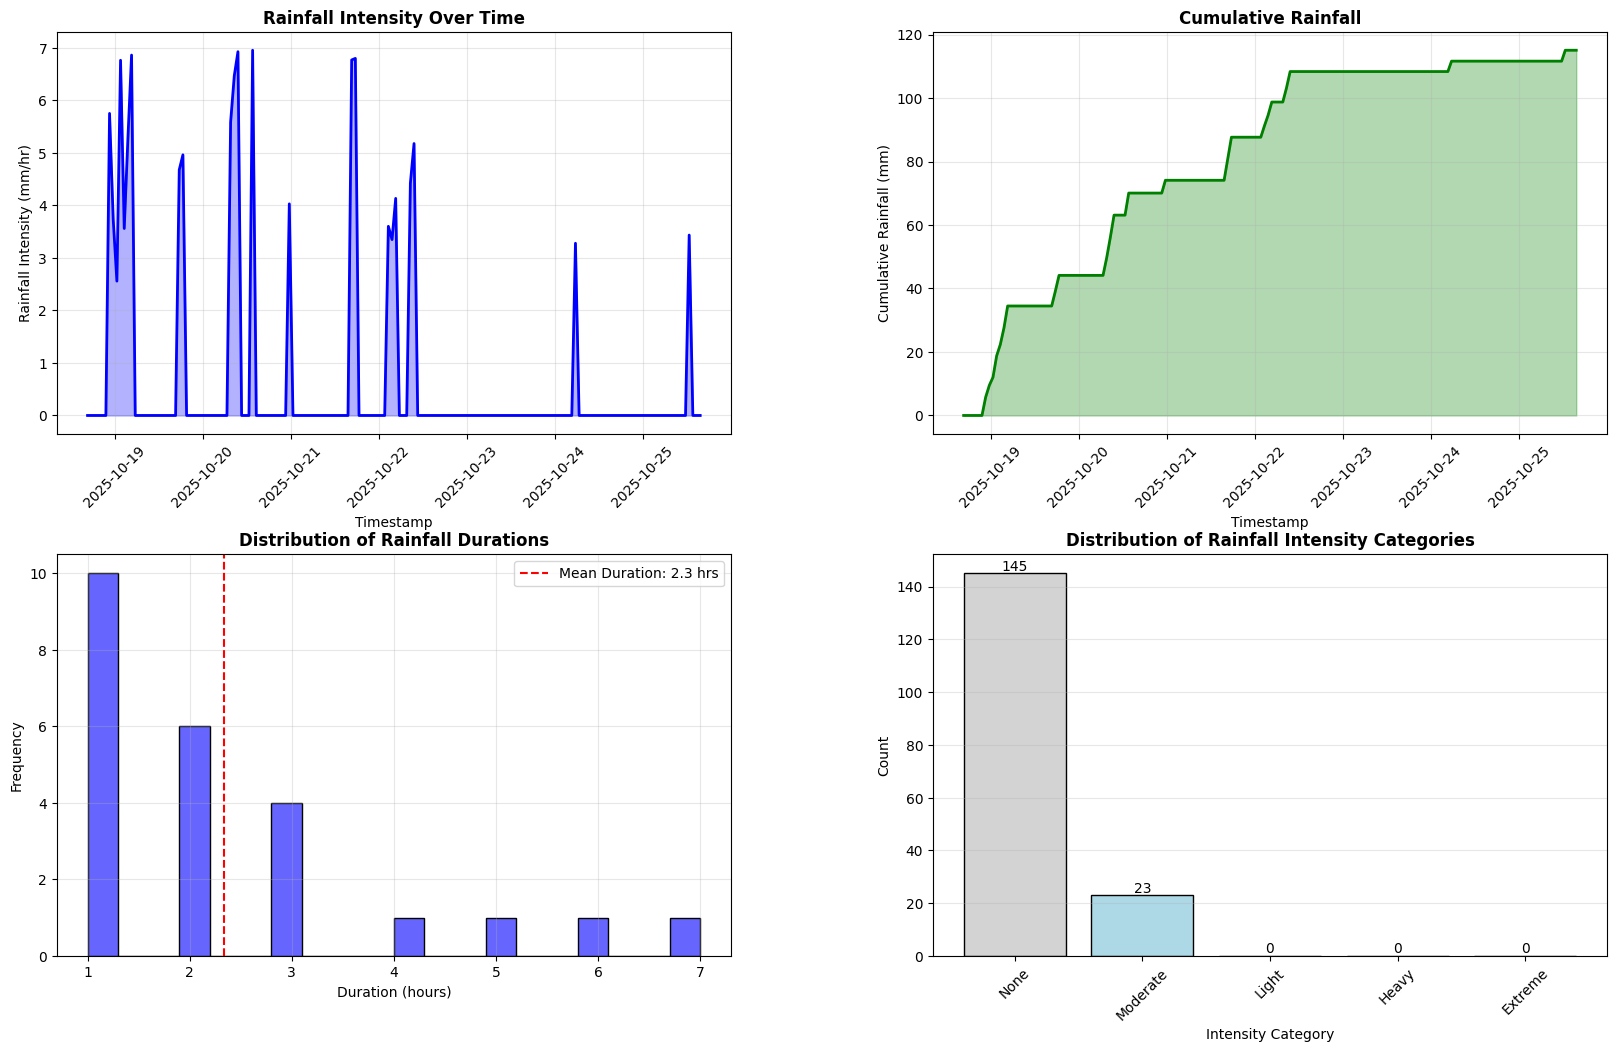


Rainfall Statistics:
--------------------------------------------------
Total Rainfall: 115.1 mm
Maximum Intensity: 7.0 mm/hr
Average Intensity (when raining): 5.0 mm/hr
Number of Rain Events: 23

Rainfall Intensity Categories:
rain_intensity_category
None        145
Moderate     23
Light         0
Heavy         0
Extreme       0


In [19]:
# Create rainfall analysis plots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Rainfall Intensity Timeline
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(processed_df['timestamp'], processed_df['rainfall_intensity'],
         color='blue', linewidth=2, label='Intensity')
ax1.fill_between(processed_df['timestamp'], processed_df['rainfall_intensity'],
                 alpha=0.3, color='blue')
ax1.set_title('Rainfall Intensity Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Rainfall Intensity (mm/hr)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Cumulative Rainfall
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(processed_df['timestamp'], processed_df['cumulative_rainfall'],
         color='green', linewidth=2)
ax2.fill_between(processed_df['timestamp'], processed_df['cumulative_rainfall'],
                 alpha=0.3, color='green')
ax2.set_title('Cumulative Rainfall', fontsize=12, fontweight='bold')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Cumulative Rainfall (mm)')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Rainfall Duration Distribution
ax3 = fig.add_subplot(gs[1, 0])
rain_durations = processed_df[processed_df['rainfall_duration'] > 0]['rainfall_duration']
if len(rain_durations) > 0:  # Only plot if we have rain events
    sns.histplot(data=rain_durations, bins=20, color='blue', alpha=0.6, ax=ax3)
    ax3.axvline(rain_durations.mean(), color='red', linestyle='--',
                label=f'Mean Duration: {rain_durations.mean():.1f} hrs')
ax3.set_title('Distribution of Rainfall Durations', fontsize=12, fontweight='bold')
ax3.set_xlabel('Duration (hours)')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Rainfall Intensity Categories
ax4 = fig.add_subplot(gs[1, 1])
category_counts = processed_df['rain_intensity_category'].value_counts()
colors = ['lightgray', 'lightblue', 'blue', 'darkblue', 'purple']
bars = ax4.bar(category_counts.index, category_counts.values,
               color=colors, edgecolor='black', linewidth=1)
ax4.set_title('Distribution of Rainfall Intensity Categories',
              fontsize=12, fontweight='bold')
ax4.set_xlabel('Intensity Category')
ax4.set_ylabel('Count')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()

# Save figure to images folder with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'rainfall_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Print rainfall statistics
print("\nRainfall Statistics:")
print("-" * 50)
print(f"Total Rainfall: {processed_df['cumulative_rainfall'].max():.1f} mm")
print(f"Maximum Intensity: {processed_df['rainfall_intensity'].max():.1f} mm/hr")
print(f"Average Intensity (when raining): {processed_df[processed_df['rainfall_intensity'] > 0]['rainfall_intensity'].mean():.1f} mm/hr")
print(f"Number of Rain Events: {len(processed_df[processed_df['rainfall_intensity'] > 0])}")
print("\nRainfall Intensity Categories:")
print(processed_df['rain_intensity_category'].value_counts().to_string())

## 5. Temperature and Humidity Analysis

Analyze temperature and humidity patterns, including their relationship and daily cycles.

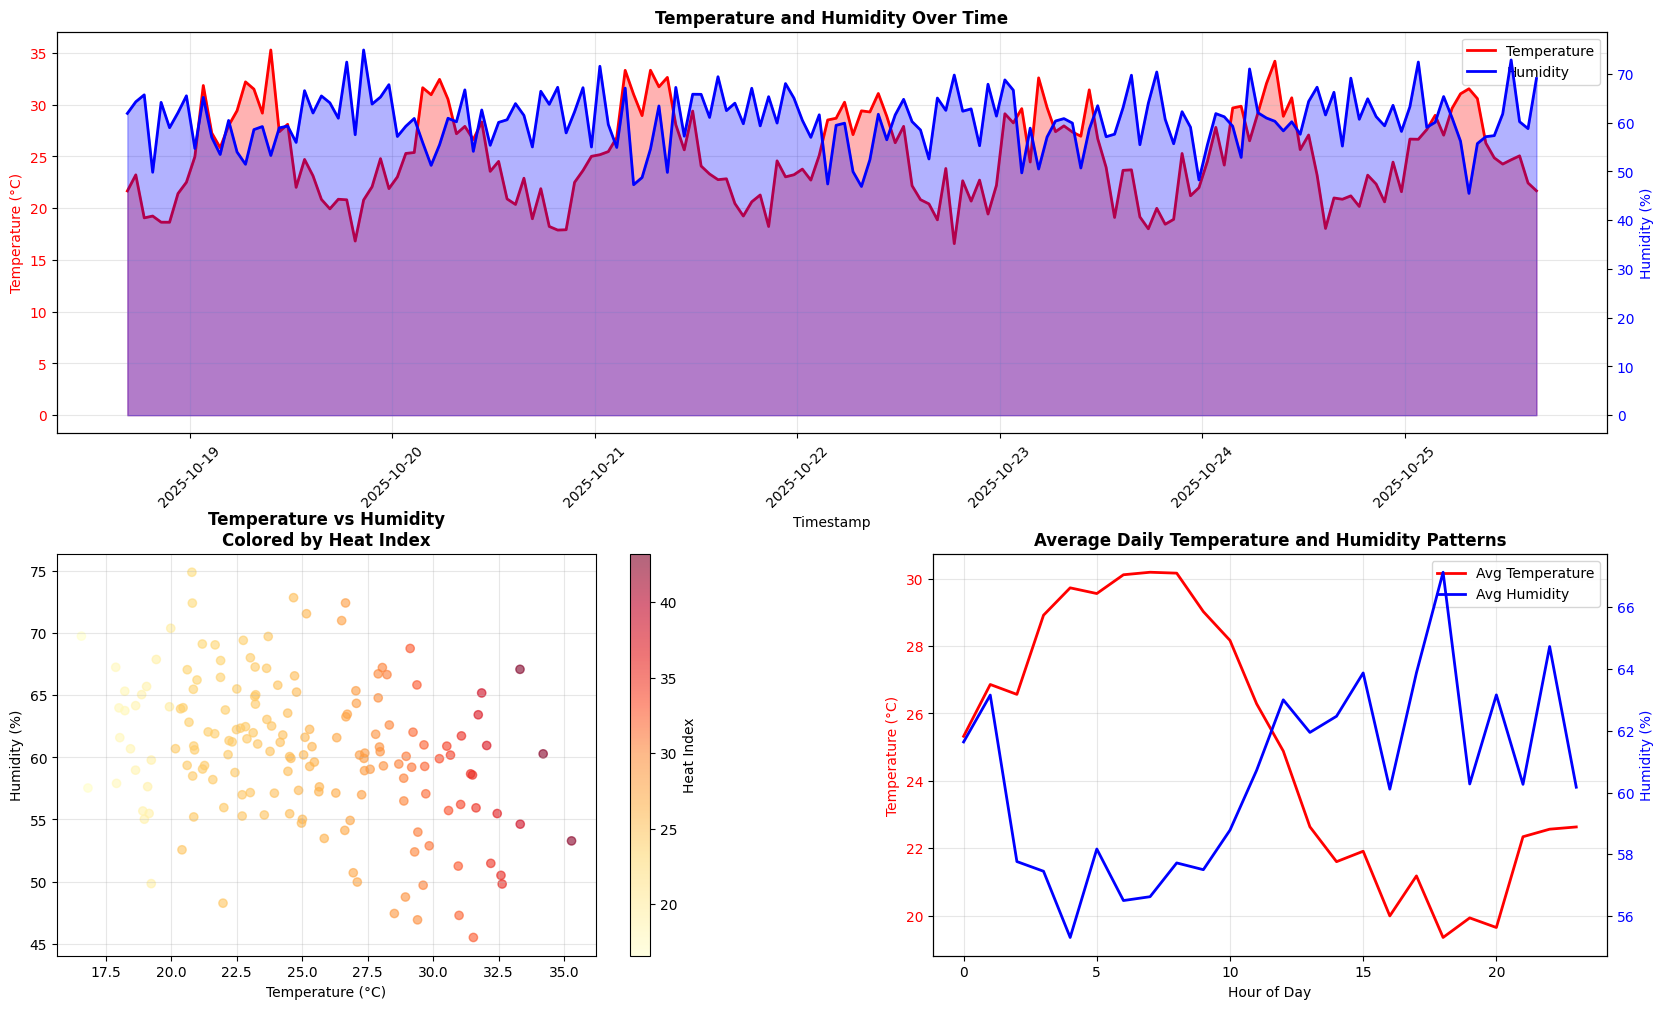


Temperature Statistics:
--------------------------------------------------
Average Temperature: 25.0°C
Maximum Temperature: 35.3°C
Minimum Temperature: 16.6°C
Temperature Range: 18.7°C

Humidity Statistics:
--------------------------------------------------
Average Humidity: 60.5%
Maximum Humidity: 74.9%
Minimum Humidity: 45.5%

Heat Index Statistics:
--------------------------------------------------
Average Heat Index: 26.8°C
Maximum Heat Index: 43.2°C
Hours with Potential Heat Stress (Heat Index > 30°C): 42


In [20]:
# Create temperature and humidity analysis plots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Temperature and Humidity Over Time
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df['timestamp'], processed_df['temperature'],
         color='red', linewidth=2, label='Temperature')
ax2 = ax1.twinx()
ax2.plot(processed_df['timestamp'], processed_df['humidity'],
         color='blue', linewidth=2, label='Humidity')

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Temperature (°C)', color='red')
ax2.set_ylabel('Humidity (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.set_title('Temperature and Humidity Over Time',
              fontsize=12, fontweight='bold')

# 2. Temperature-Humidity Scatter Plot
ax3 = fig.add_subplot(gs[1, 0])
scatter = ax3.scatter(processed_df['temperature'], processed_df['humidity'],
                     c=processed_df['heat_index'], cmap='YlOrRd',
                     alpha=0.6)
plt.colorbar(scatter, ax=ax3, label='Heat Index')
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('Humidity (%)')
ax3.set_title('Temperature vs Humidity\nColored by Heat Index',
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 3. Daily Temperature and Humidity Patterns
ax4 = fig.add_subplot(gs[1, 1])
hourly_stats = processed_df.groupby('hour').agg({
    'temperature': 'mean',
    'humidity': 'mean'
}).reset_index()

ax4.plot(hourly_stats['hour'], hourly_stats['temperature'],
         color='red', linewidth=2, label='Avg Temperature')
ax4_twin = ax4.twinx()
ax4_twin.plot(hourly_stats['hour'], hourly_stats['humidity'],
              color='blue', linewidth=2, label='Avg Humidity')

ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Temperature (°C)', color='red')
ax4_twin.set_ylabel('Humidity (%)', color='blue')
ax4.tick_params(axis='y', labelcolor='red')
ax4_twin.tick_params(axis='y', labelcolor='blue')
ax4.grid(True, alpha=0.3)

# Combine legends
lines4, labels4 = ax4.get_legend_handles_labels()
lines4_twin, labels4_twin = ax4_twin.get_legend_handles_labels()
ax4.legend(lines4 + lines4_twin, labels4 + labels4_twin, loc='upper right')
ax4.set_title('Average Daily Temperature and Humidity Patterns',
              fontsize=12, fontweight='bold')

plt.tight_layout()

# Save figure to images folder with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'temperature_humidity_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Print temperature and humidity statistics
print("\nTemperature Statistics:")
print("-" * 50)
print(f"Average Temperature: {processed_df['temperature'].mean():.1f}°C")
print(f"Maximum Temperature: {processed_df['temperature'].max():.1f}°C")
print(f"Minimum Temperature: {processed_df['temperature'].min():.1f}°C")
print(f"Temperature Range: {processed_df['temperature'].max() - processed_df['temperature'].min():.1f}°C")

print("\nHumidity Statistics:")
print("-" * 50)
print(f"Average Humidity: {processed_df['humidity'].mean():.1f}%")
print(f"Maximum Humidity: {processed_df['humidity'].max():.1f}%")
print(f"Minimum Humidity: {processed_df['humidity'].min():.1f}%")

print("\nHeat Index Statistics:")
print("-" * 50)
print(f"Average Heat Index: {processed_df['heat_index'].mean():.1f}°C")
print(f"Maximum Heat Index: {processed_df['heat_index'].max():.1f}°C")
print("Hours with Potential Heat Stress (Heat Index > 30°C):",
      len(processed_df[processed_df['heat_index'] > 30]))


## 6. Wind Speed Analysis

Analyze wind patterns and create wind speed distribution visualizations.

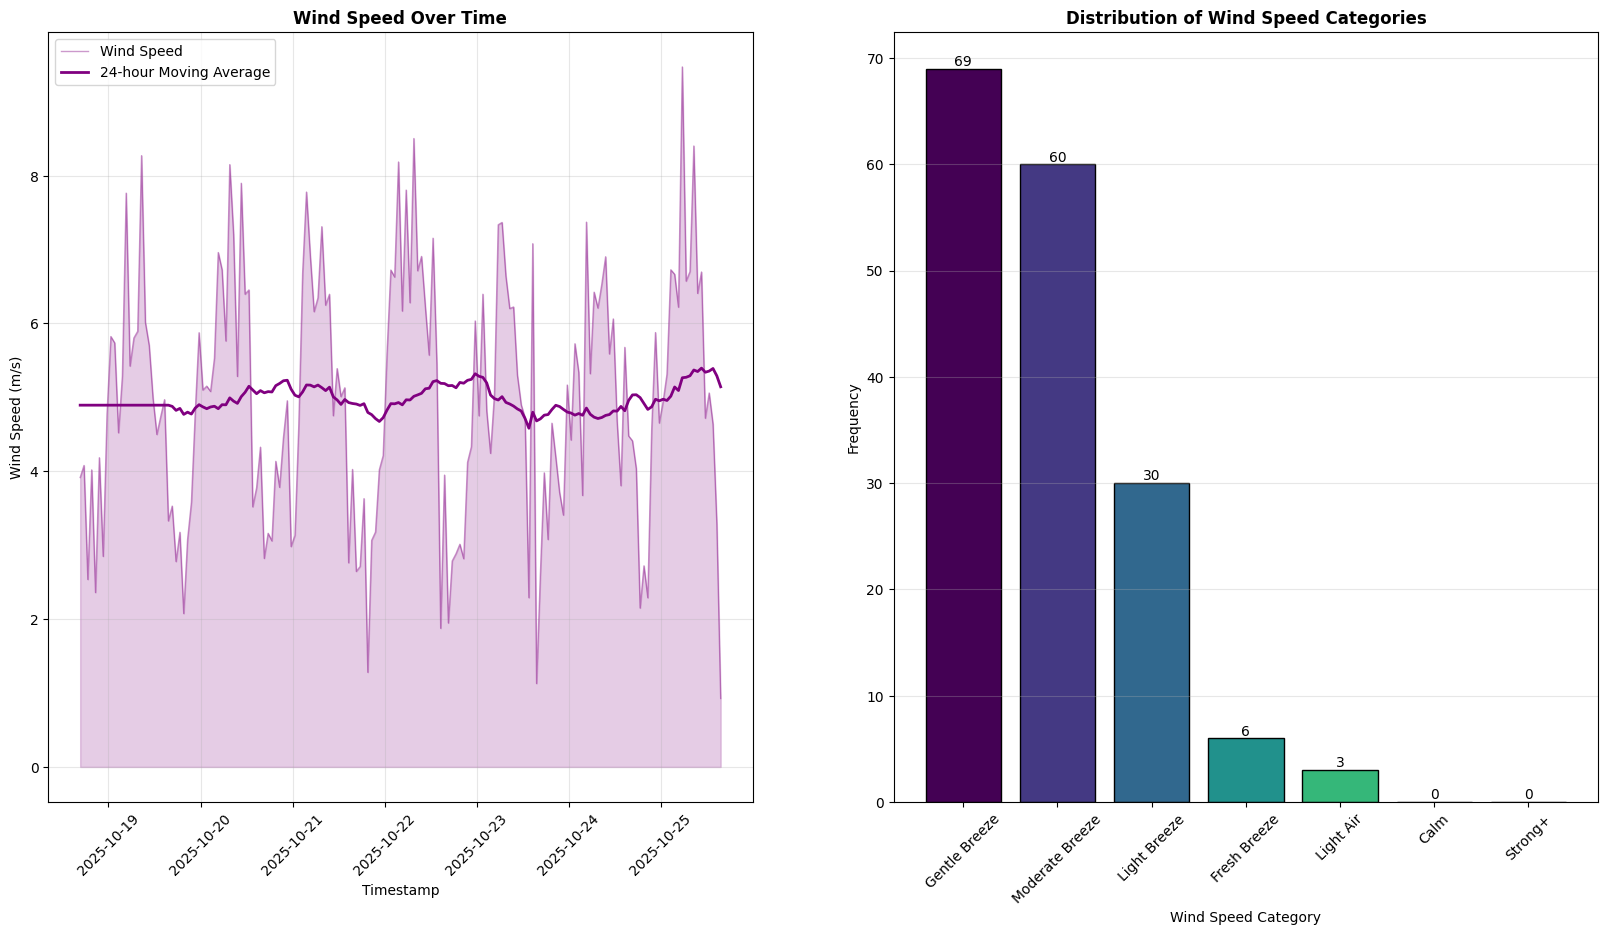

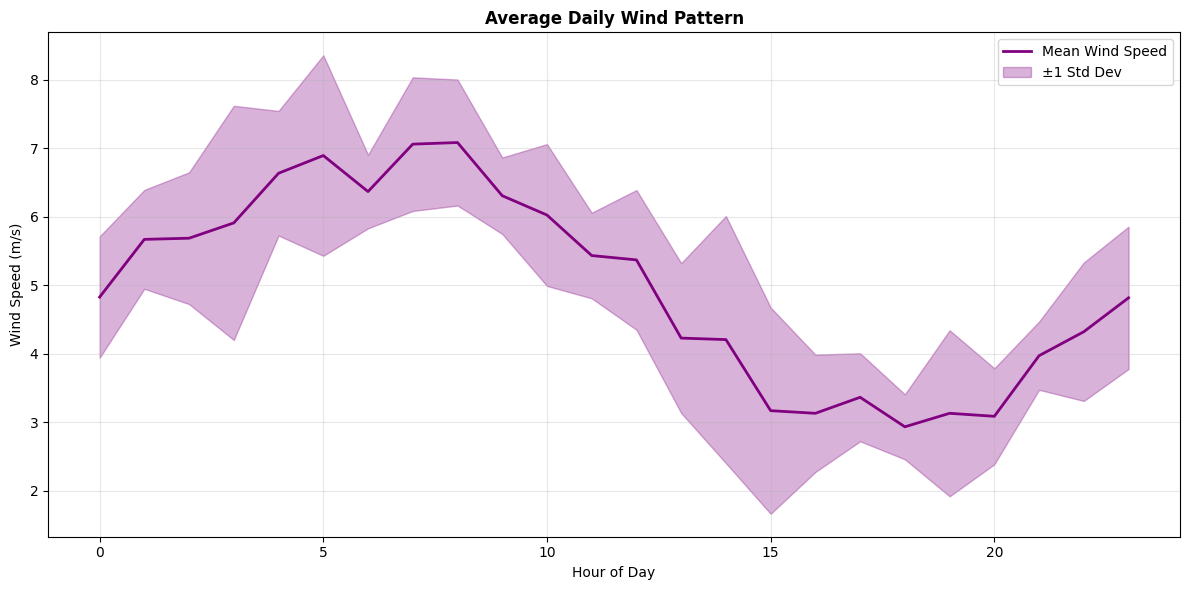


Wind Speed Statistics:
--------------------------------------------------
Average Wind Speed: 5.0 m/s
Maximum Wind Speed: 9.5 m/s
Minimum Wind Speed: 0.9 m/s
Standard Deviation: 1.7 m/s

Wind Speed Categories Distribution:
--------------------------------------------------
wind_speed
Gentle Breeze      69
Moderate Breeze    60
Light Breeze       30
Fresh Breeze        6
Light Air           3
Calm                0
Strong+             0

Wind Speed Percentiles:
--------------------------------------------------
25th percentile: 3.8 m/s
50th percentile: 5.0 m/s
75th percentile: 6.2 m/s
90th percentile: 7.0 m/s
95th percentile: 7.8 m/s


In [21]:
# Create wind speed analysis plots
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.2)

# 1. Wind Speed Timeline with Moving Average
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(processed_df['timestamp'], processed_df['wind_speed'],
         color='purple', alpha=0.4, linewidth=1, label='Wind Speed')
ax1.plot(processed_df['timestamp'], processed_df['wind_speed_ma_24h'],
         color='purple', linewidth=2, label='24-hour Moving Average')
ax1.fill_between(processed_df['timestamp'], processed_df['wind_speed'],
                 alpha=0.2, color='purple')
ax1.set_title('Wind Speed Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Wind Speed (m/s)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# 2. Wind Speed Distribution and Categories
ax2 = fig.add_subplot(gs[0, 1])
# Define wind speed categories
wind_categories = pd.cut(processed_df['wind_speed'],
                        bins=[0, 0.5, 1.5, 3.3, 5.5, 7.9, 10.7, float('inf')],
                        labels=['Calm', 'Light Air', 'Light Breeze', 
                               'Gentle Breeze', 'Moderate Breeze',
                               'Fresh Breeze', 'Strong+'])
wind_dist = wind_categories.value_counts()

colors = plt.cm.viridis(np.linspace(0, 1, len(wind_dist)))
bars = ax2.bar(wind_dist.index, wind_dist.values, color=colors,
               edgecolor='black', linewidth=1)
ax2.set_title('Distribution of Wind Speed Categories',
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Wind Speed Category')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()

# Save figure to images folder with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'wind_speed_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Create daily wind pattern plot
plt.figure(figsize=(12, 6))
hourly_wind = processed_df.groupby('hour')['wind_speed'].agg(['mean', 'std']).reset_index()

plt.plot(hourly_wind['hour'], hourly_wind['mean'],
         color='purple', linewidth=2, label='Mean Wind Speed')
plt.fill_between(hourly_wind['hour'],
                 hourly_wind['mean'] - hourly_wind['std'],
                 hourly_wind['mean'] + hourly_wind['std'],
                 alpha=0.3, color='purple', label='±1 Std Dev')
plt.title('Average Daily Wind Pattern', fontsize=12, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Save daily wind pattern
image_path2 = get_next_filename(IMAGES_DIR, 'wind_daily_pattern', '.png')
plt.savefig(image_path2, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path2}")

plt.show()

# Print wind speed statistics
print("\nWind Speed Statistics:")
print("-" * 50)
print(f"Average Wind Speed: {processed_df['wind_speed'].mean():.1f} m/s")
print(f"Maximum Wind Speed: {processed_df['wind_speed'].max():.1f} m/s")
print(f"Minimum Wind Speed: {processed_df['wind_speed'].min():.1f} m/s")
print(f"Standard Deviation: {processed_df['wind_speed'].std():.1f} m/s")

print("\nWind Speed Categories Distribution:")
print("-" * 50)
print(wind_categories.value_counts().to_string())

# Calculate wind speed percentiles
percentiles = [25, 50, 75, 90, 95]
wind_percentiles = np.percentile(processed_df['wind_speed'], percentiles)

print("\nWind Speed Percentiles:")
print("-" * 50)
for p, v in zip(percentiles, wind_percentiles):
    print(f"{p}th percentile: {v:.1f} m/s")


## 7. Weather Parameter Correlations

Analyze relationships between different weather parameters using correlation analysis and visualization.

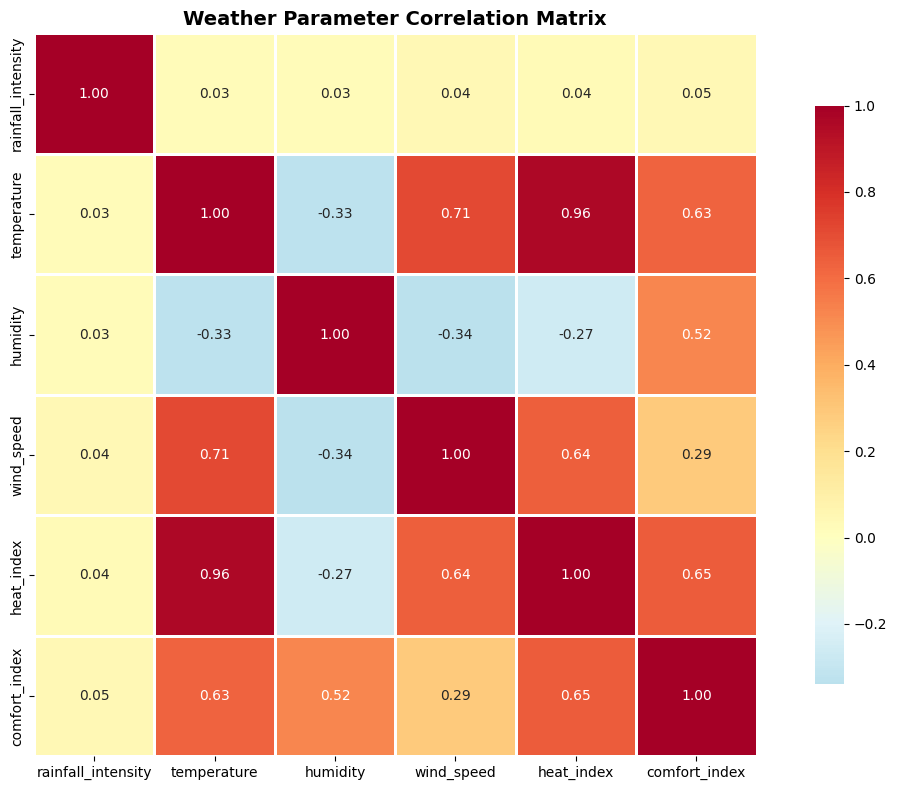

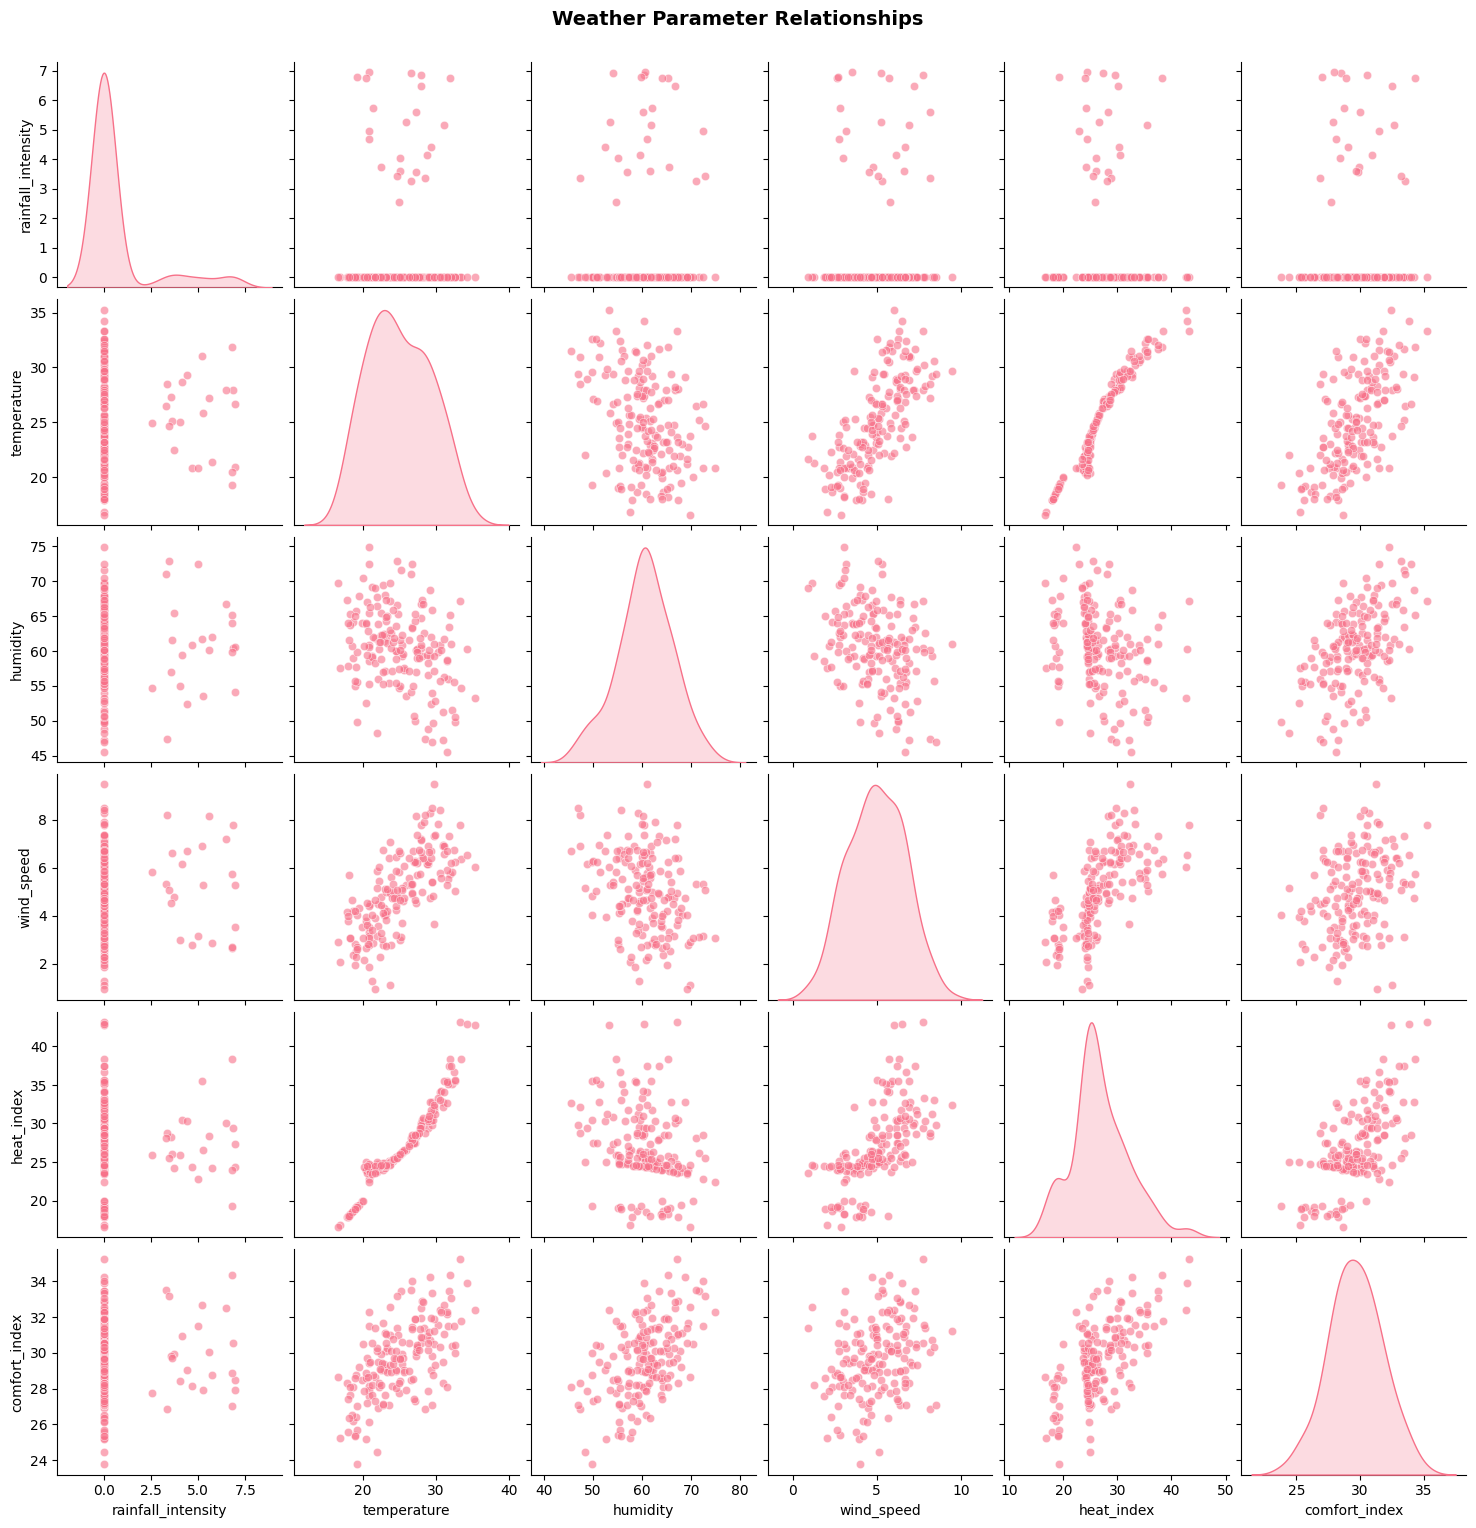


Key Weather Parameter Correlations:
--------------------------------------------------
rainfall_intensity vs temperature: 0.029
rainfall_intensity vs wind_speed: 0.038
temperature vs wind_speed: 0.713
humidity vs rainfall_intensity: 0.029
humidity vs temperature: -0.330
humidity vs wind_speed: -0.339
heat_index vs rainfall_intensity: 0.037
heat_index vs temperature: 0.963
heat_index vs humidity: -0.266
heat_index vs wind_speed: 0.644
comfort_index vs rainfall_intensity: 0.046
comfort_index vs temperature: 0.626
comfort_index vs humidity: 0.522
comfort_index vs wind_speed: 0.286
comfort_index vs heat_index: 0.651

Key Weather Patterns:
--------------------------------------------------
Temperature-Humidity correlation: -0.330
Weak inverse relationship between temperature and humidity

Rainfall-Temperature correlation: 0.029
Weak correlation between rainfall and temperature

Wind-Temperature correlation: 0.713
Significant correlation between wind speed and temperature


In [22]:
# Select relevant columns for correlation analysis
correlation_columns = ['rainfall_intensity', 'temperature', 'humidity', 'wind_speed',
                      'heat_index', 'comfort_index']

# Calculate correlation matrix
correlation_matrix = processed_df[correlation_columns].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.2f', square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Weather Parameter Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save correlation heatmap
image_path = get_next_filename(IMAGES_DIR, 'correlation_heatmap', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Create pairplot for detailed relationship visualization
pairplot_fig = sns.pairplot(processed_df[correlation_columns], diag_kind='kde',
             plot_kws={'alpha': 0.6})
plt.suptitle('Weather Parameter Relationships', y=1.02, fontsize=14, fontweight='bold')

# Save pairplot
image_path2 = get_next_filename(IMAGES_DIR, 'parameter_relationships', '.png')
pairplot_fig.savefig(image_path2, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path2}")

plt.show()

# Calculate and print key correlations
print("\nKey Weather Parameter Correlations:")
print("-" * 50)
for col1 in correlation_columns:
    for col2 in correlation_columns:
        if col1 < col2:  # Avoid printing duplicate correlations
            corr = correlation_matrix.loc[col1, col2]
            print(f"{col1} vs {col2}: {corr:.3f}")

# Analyze specific relationships
print("\nKey Weather Patterns:")
print("-" * 50)

# Temperature-Humidity relationship
temp_humid_corr = np.corrcoef(processed_df['temperature'], processed_df['humidity'])[0,1]
print(f"Temperature-Humidity correlation: {temp_humid_corr:.3f}")
if temp_humid_corr < -0.5:
    print("Strong inverse relationship between temperature and humidity")
elif temp_humid_corr < 0:
    print("Weak inverse relationship between temperature and humidity")
else:
    print("Positive relationship between temperature and humidity")

# Wind Speed-Rain relationship
wind_temp_corr = np.corrcoef(processed_df['wind_speed'], processed_df['temperature'])[0,1]
print(f"\nWind Speed-Temperature correlation: {wind_temp_corr:.3f}")

# Rain-Temperature relationship
rain_temp_corr = np.corrcoef(processed_df['rainfall_intensity'], processed_df['temperature'])[0,1]
print(f"Rainfall-Temperature correlation: {rain_temp_corr:.3f}")


## 8. Weather Alert System

Implement a basic weather alert system based on thresholds for different weather parameters.

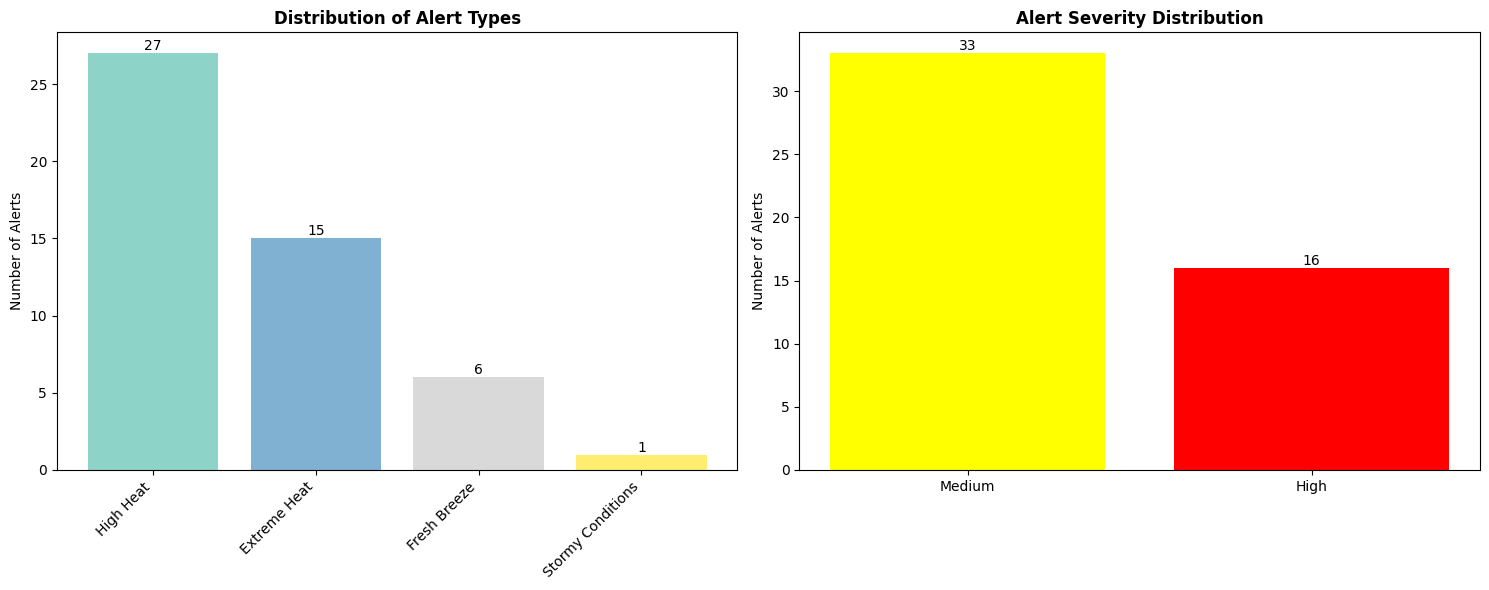

Weather Alert Summary:
--------------------------------------------------
Total number of alerts: 49

Alerts by type:
type
High Heat            27
Extreme Heat         15
Fresh Breeze          6
Stormy Conditions     1

Alerts by severity:
severity
Medium    33
High      16

Most Recent Alerts:
--------------------------------------------------
[2025-10-25 08:37:34.516571] Medium - Fresh breeze conditions: 8.4 m/s
[2025-10-25 08:37:34.516571] Medium - High heat conditions: Heat index 33.1°C
[2025-10-25 07:37:34.516571] Medium - High heat conditions: Heat index 32.6°C
[2025-10-25 06:37:34.516571] Medium - High heat conditions: Heat index 34.0°C
[2025-10-25 05:37:34.516571] Medium - Fresh breeze conditions: 9.5 m/s


In [23]:
def check_weather_alerts(data):
    """
    Check for weather alerts based on various thresholds.
    Returns a list of alerts and their severity.
    """
    alerts = []
    
    # Rainfall alerts
    if data['rainfall_intensity'] > 15:
        alerts.append({
            'type': 'Extreme Rainfall',
            'severity': 'High',
            'message': f"Extreme rainfall detected: {data['rainfall_intensity']:.1f} mm/hr"
        })
    elif data['rainfall_intensity'] > 7.5:
        alerts.append({
            'type': 'Heavy Rainfall',
            'severity': 'Medium',
            'message': f"Heavy rainfall detected: {data['rainfall_intensity']:.1f} mm/hr"
        })
    
    # Heat index alerts
    if data['heat_index'] > 35:
        alerts.append({
            'type': 'Extreme Heat',
            'severity': 'High',
            'message': f"Dangerous heat conditions: Heat index {data['heat_index']:.1f}°C"
        })
    elif data['heat_index'] > 30:
        alerts.append({
            'type': 'High Heat',
            'severity': 'Medium',
            'message': f"High heat conditions: Heat index {data['heat_index']:.1f}°C"
        })
    
    # Wind speed alerts
    if data['wind_speed'] > 10.7:
        alerts.append({
            'type': 'Strong Winds',
            'severity': 'High',
            'message': f"Strong winds detected: {data['wind_speed']:.1f} m/s"
        })
    elif data['wind_speed'] > 7.9:
        alerts.append({
            'type': 'Fresh Breeze',
            'severity': 'Medium',
            'message': f"Fresh breeze conditions: {data['wind_speed']:.1f} m/s"
        })
    
    # Combined condition alerts
    if data['rainfall_intensity'] > 5 and data['wind_speed'] > 8:
        alerts.append({
            'type': 'Stormy Conditions',
            'severity': 'High',
            'message': "Heavy rain with strong winds detected"
        })
    
    return alerts

# Process alerts for the entire dataset
all_alerts = []
for idx, row in processed_df.iterrows():
    timestamp = row['timestamp']
    alerts = check_weather_alerts(row)
    for alert in alerts:
        alert['timestamp'] = timestamp
        all_alerts.append(alert)

# Convert alerts to DataFrame
alerts_df = pd.DataFrame(all_alerts)

if len(alerts_df) > 0:
    # Plot alert distribution
    plt.figure(figsize=(15, 6))
    
    # Alert counts by type
    plt.subplot(1, 2, 1)
    alert_counts = alerts_df['type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(alert_counts)))
    bars = plt.bar(alert_counts.index, alert_counts.values, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Alert Types', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Alerts')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    # Alert severity distribution
    plt.subplot(1, 2, 2)
    severity_counts = alerts_df['severity'].value_counts()
    colors = {'High': 'red', 'Medium': 'yellow'}
    bars = plt.bar(severity_counts.index, severity_counts.values,
                  color=[colors[s] for s in severity_counts.index])
    plt.title('Alert Severity Distribution', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Alerts')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Save alert visualization
    image_path = get_next_filename(IMAGES_DIR, 'weather_alerts', '.png')
    plt.savefig(image_path, dpi=300, bbox_inches='tight')
    print(f\"✓ Image saved: {image_path}\")
    
    plt.show()
    
    # Print alert summary
    print(\"Weather Alert Summary:\")
    print("-" * 50)
    print(f"Total number of alerts: {len(alerts_df)}")
    print(f"\nAlerts by type:")
    print(alerts_df['type'].value_counts().to_string())
    print(f"\nAlerts by severity:")
    print(alerts_df['severity'].value_counts().to_string())
    
    # Print the most recent alerts
    print("\nMost Recent Alerts:")
    print("-" * 50)
    recent_alerts = alerts_df.sort_values('timestamp', ascending=False).head(5)
    for _, alert in recent_alerts.iterrows():
        print(f"[{alert['timestamp']}] {alert['severity']} - {alert['message']}")
else:
    print("No weather alerts generated for the current data.")

## 9. Interactive Time Series Dashboard

Create an interactive dashboard for visualizing all weather parameters using Plotly.

In [24]:
# Create an interactive dashboard using plotly
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Temperature and Heat Index',
        'Rainfall Intensity and Accumulation',
        'Humidity',
        'Wind Speed',
        'Comfort Index',
        'Parameter Correlations'
    ),
    specs=[
        [{"secondary_y": True}, {"secondary_y": True}],
        [{"secondary_y": False}, {"secondary_y": False}],
        [{"secondary_y": False}, {"type": "scatter"}]
    ]
)

# 1. Temperature and Heat Index
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['temperature'],
               name='Temperature', line=dict(color='red')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['heat_index'],
               name='Heat Index', line=dict(color='orange', dash='dash')),
    row=1, col=1
)

# 2. Rainfall
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['rainfall_intensity'],
               name='Rainfall Intensity', line=dict(color='blue')),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['cumulative_rainfall'],
               name='Cumulative Rainfall', line=dict(color='lightblue')),
    row=1, col=2, secondary_y=True
)

# 3. Humidity
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['humidity'],
               name='Humidity', line=dict(color='green')),
    row=2, col=1
)

# 4. Wind Speed
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['wind_speed'],
               name='Wind Speed', line=dict(color='purple')),
    row=2, col=2
)

# 5. Comfort Index
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['comfort_index'],
               name='Comfort Index', line=dict(color='brown')),
    row=3, col=1
)

# 6. Parameter Correlations
# Create correlation scatter between temperature and humidity
fig.add_trace(
    go.Scatter(
        x=processed_df['temperature'],
        y=processed_df['humidity'],
        mode='markers',
        name='Temp-Humidity',
        marker=dict(
            size=8,
            color=processed_df['comfort_index'],
            colorscale='RdYlBu_r',
            showscale=True,
            colorbar=dict(title='Comfort Index')
        )
    ),
    row=3, col=2
)

# Update layout
fig.update_layout(
    height=1000,
    width=1200,
    showlegend=True,
    title_text="Weather Station Dashboard",
    title_x=0.5,
    title_font=dict(size=24)
)

# Update axes labels
fig.update_xaxes(title_text="Timestamp", row=1, col=1)
fig.update_xaxes(title_text="Timestamp", row=1, col=2)
fig.update_xaxes(title_text="Timestamp", row=2, col=1)
fig.update_xaxes(title_text="Timestamp", row=2, col=2)
fig.update_xaxes(title_text="Timestamp", row=3, col=1)
fig.update_xaxes(title_text="Temperature (°C)", row=3, col=2)

fig.update_yaxes(title_text="Temperature (°C)", row=1, col=1)
fig.update_yaxes(title_text="Rainfall Intensity (mm/hr)", row=1, col=2)
fig.update_yaxes(title_text="Cumulative Rainfall (mm)", secondary_y=True, row=1, col=2)
fig.update_yaxes(title_text="Humidity (%)", row=2, col=1)
fig.update_yaxes(title_text="Wind Speed (m/s)", row=2, col=2)
fig.update_yaxes(title_text="Comfort Index", row=3, col=1)
fig.update_yaxes(title_text="Humidity (%)", row=3, col=2)

# Show the interactive dashboard
fig.show()

# Print summary statistics
print("Weather Station Data Summary:")
print("-" * 50)
print(f"Data Period: {processed_df['timestamp'].min()} to {processed_df['timestamp'].max()}")
print(f"Total Records: {len(processed_df)}")
print("\nParameter Ranges:")
print("-" * 50)
for column in ['temperature', 'humidity', 'wind_speed', 'rainfall_intensity']:
    data = processed_df[column]
    print(f"\n{column.replace('_', ' ').title()}:")
    print(f"  Min: {data.min():.1f}")
    print(f"  Max: {data.max():.1f}")
    print(f"  Mean: {data.mean():.1f}")
    print(f"  Std Dev: {data.std():.1f}")

# Save the processed data to Analysis directory (with Non-Overwrite)
PROCESSED_DATA_FILE = get_next_filename(ANALYSIS_DIR, 'processed_weather_data', '.csv')
processed_df.to_csv(PROCESSED_DATA_FILE, index=False)
print(f"\n✓ Processed data saved to: {PROCESSED_DATA_FILE}")

Weather Station Data Summary:
--------------------------------------------------
Data Period: 2025-10-18 16:37:34.516571 to 2025-10-25 15:37:34.516571
Total Records: 168

Parameter Ranges:
--------------------------------------------------

Temperature:
  Min: 16.6
  Max: 35.3
  Mean: 25.0
  Std Dev: 4.3

Humidity:
  Min: 45.5
  Max: 74.9
  Mean: 60.5
  Std Dev: 5.7

Wind Speed:
  Min: 0.9
  Max: 9.5
  Mean: 5.0
  Std Dev: 1.7

Rainfall Intensity:
  Min: 0.0
  Max: 7.0
  Mean: 0.7
  Std Dev: 1.8

✓ Processed data saved to: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Auto_Weather_station\Analysis\processed_weather_data.csv


## 10. Advanced Statistical Analysis

Perform advanced statistical tests and trend analysis on weather data.

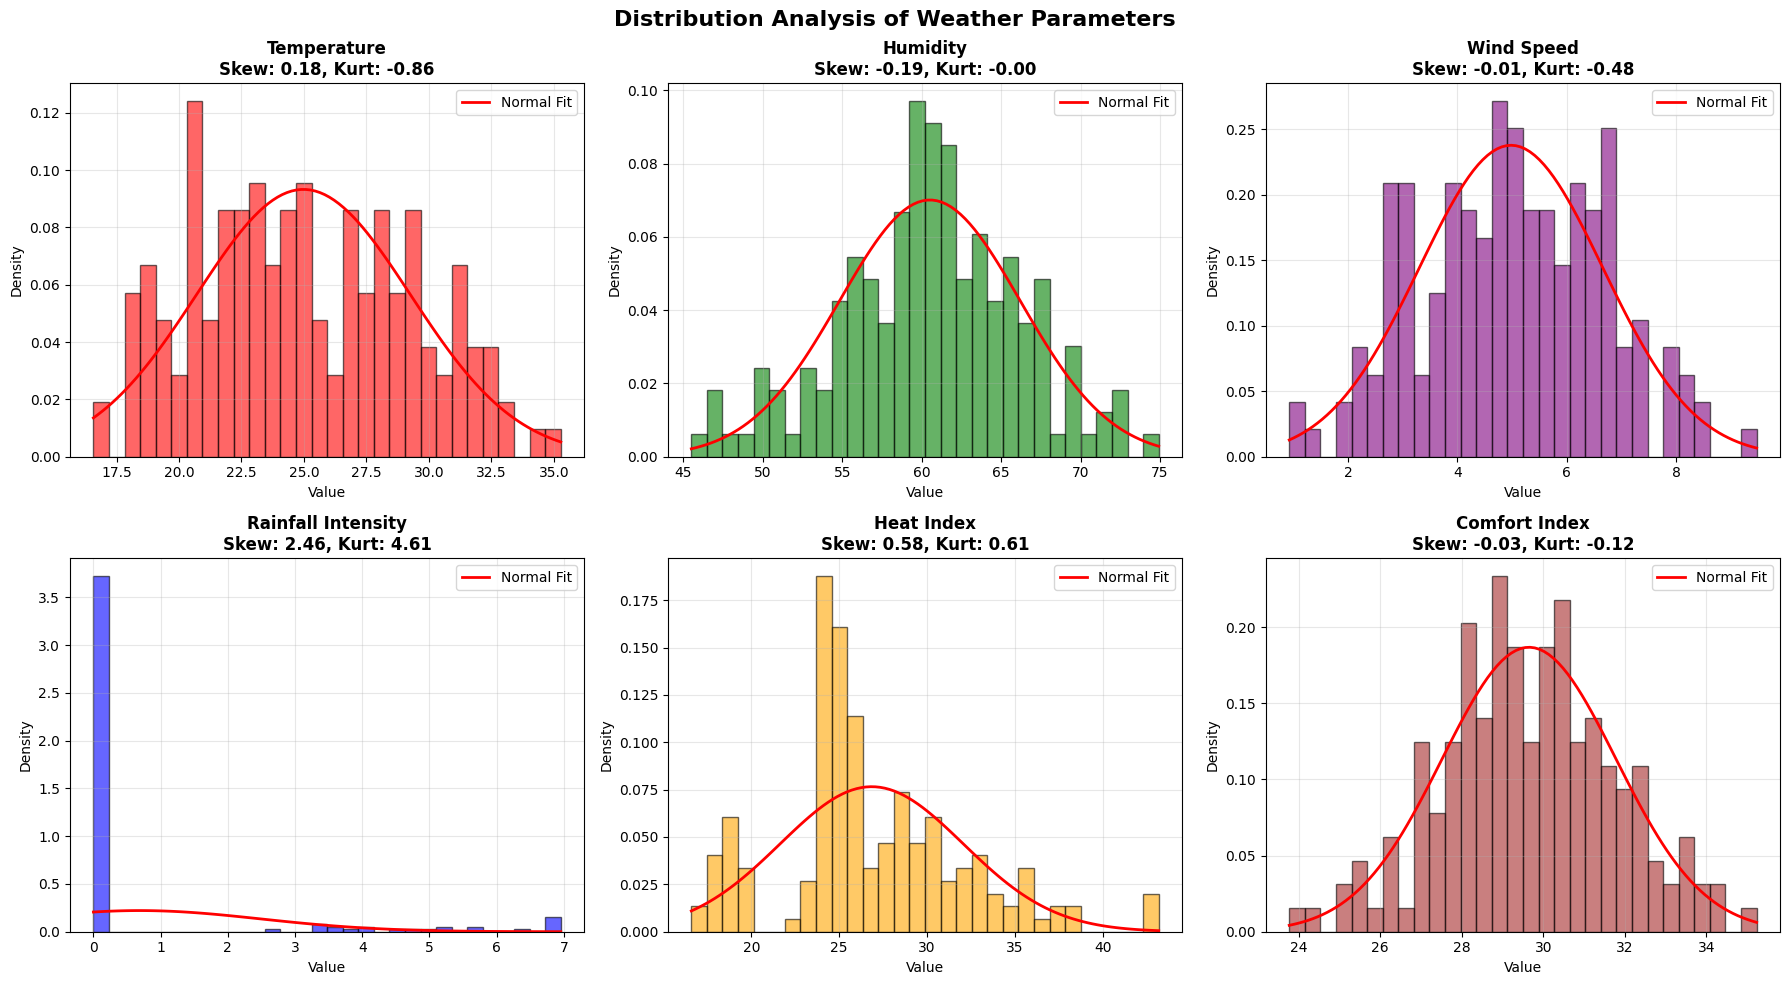

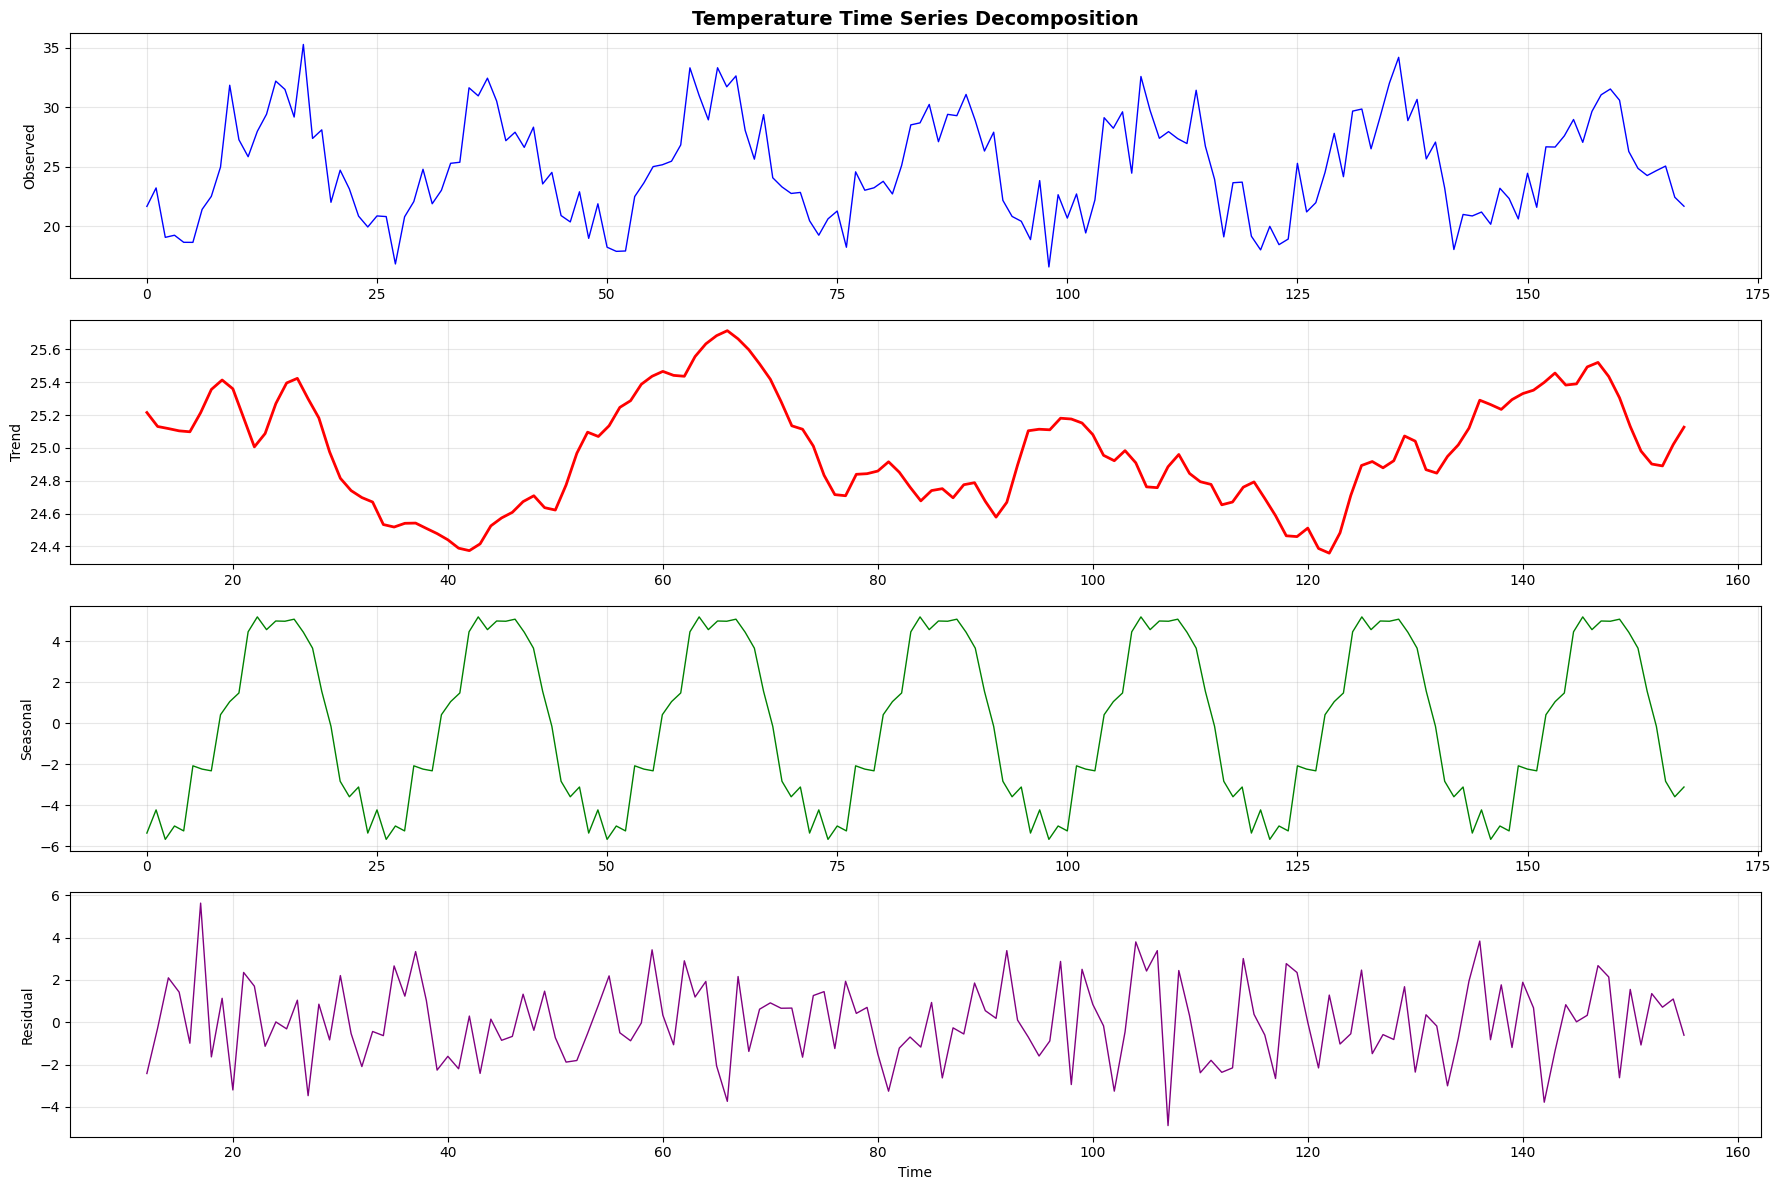

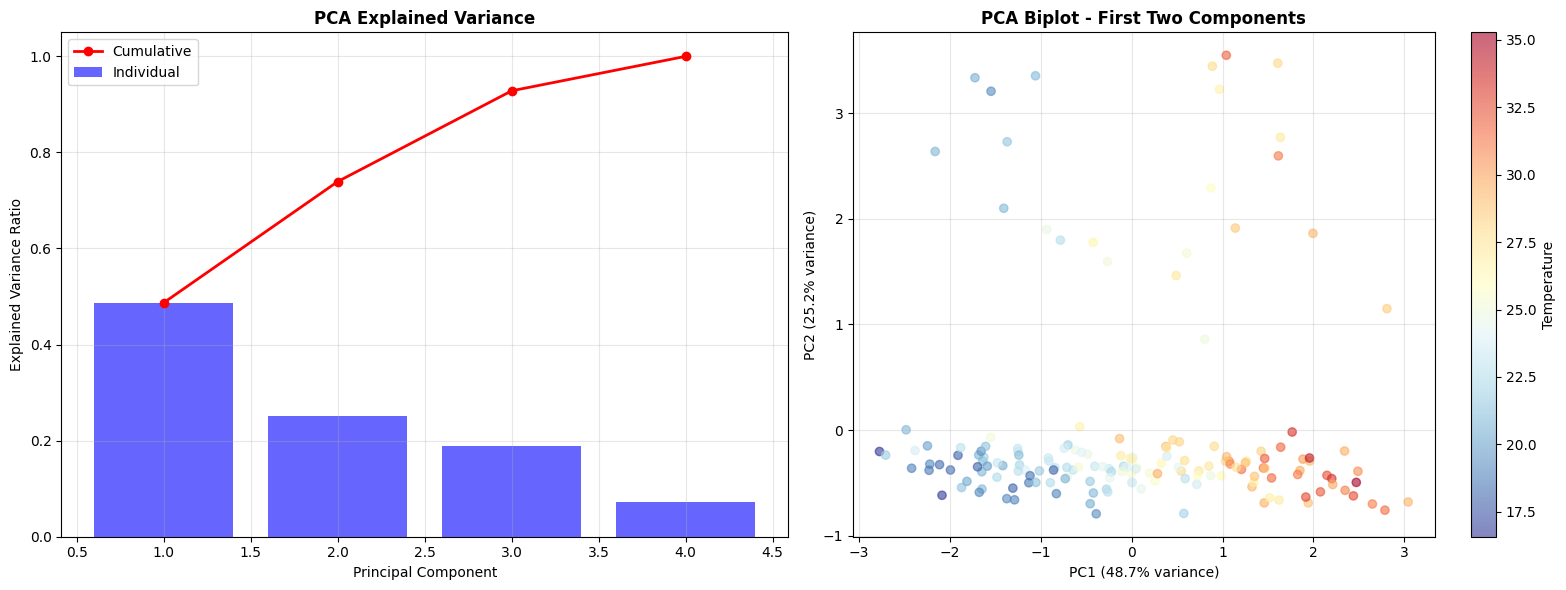

Advanced Statistical Analysis Summary:

Temperature:
  Mean: 24.98
  Median: 24.62
  Std Dev: 4.28
  Skewness: 0.177
  Kurtosis: -0.863
  Normality Test p-value: 0.0004
  Distribution: Non-normal

Humidity:
  Mean: 60.51
  Median: 60.65
  Std Dev: 5.69
  Skewness: -0.188
  Kurtosis: -0.003
  Normality Test p-value: 0.5703
  Distribution: Normal

Wind Speed:
  Mean: 4.98
  Median: 4.98
  Std Dev: 1.68
  Skewness: -0.005
  Kurtosis: -0.477
  Normality Test p-value: 0.3546
  Distribution: Normal

Rainfall Intensity:
  Mean: 0.68
  Median: 0.00
  Std Dev: 1.80
  Skewness: 2.461
  Kurtosis: 4.613
  Normality Test p-value: 0.0000
  Distribution: Non-normal

Heat Index:
  Mean: 26.85
  Median: 25.65
  Std Dev: 5.21
  Skewness: 0.580
  Kurtosis: 0.613
  Normality Test p-value: 0.0031
  Distribution: Non-normal

Comfort Index:
  Mean: 29.65
  Median: 29.64
  Std Dev: 2.14
  Skewness: -0.028
  Kurtosis: -0.121
  Normality Test p-value: 0.9838
  Distribution: Normal

PCA Analysis:
Components need

In [25]:
# Advanced Statistical Analysis
from scipy import signal
from scipy.stats import normaltest, skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Distribution Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

params = ['temperature', 'humidity', 'wind_speed', 'rainfall_intensity', 'heat_index', 'comfort_index']
colors = ['red', 'green', 'purple', 'blue', 'orange', 'brown']

for idx, (param, color) in enumerate(zip(params, colors)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    data = processed_df[param].dropna()
    
    # Histogram with KDE
    ax.hist(data, bins=30, density=True, alpha=0.6, color=color, edgecolor='black')
    
    # Fit normal distribution
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Fit')
    
    # Calculate statistics
    skewness = skew(data)
    kurt = kurtosis(data)
    stat, p_value = normaltest(data)
    
    ax.set_title(f'{param.replace("_", " ").title()}\nSkew: {skewness:.2f}, Kurt: {kurt:.2f}',
                fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribution Analysis of Weather Parameters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axes = plt.subplots(4, 1, figsize=(18, 12))

# Decompose temperature
decomposition = seasonal_decompose(processed_df['temperature'], model='additive', period=24)

axes[0].plot(decomposition.observed, color='blue', linewidth=1)
axes[0].set_ylabel('Observed')
axes[0].set_title('Temperature Time Series Decomposition', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend, color='red', linewidth=2)
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal, color='green', linewidth=1)
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition.resid, color='purple', linewidth=1)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Time')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Principal Component Analysis (PCA)
# Prepare data for PCA
pca_features = ['temperature', 'humidity', 'wind_speed', 'rainfall_intensity']
X_pca = processed_df[pca_features].dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)

# Create PCA visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Explained variance plot
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

ax1.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.6, color='blue',
        label='Individual')
ax1.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-', linewidth=2,
         label='Cumulative')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('PCA Explained Variance', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PCA biplot
ax2.scatter(principal_components[:, 0], principal_components[:, 1],
           c=processed_df['temperature'][:len(principal_components)],
           cmap='RdYlBu_r', alpha=0.6)
ax2.set_xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
ax2.set_title('PCA Biplot - First Two Components', fontsize=12, fontweight='bold')
plt.colorbar(ax2.collections[0], ax=ax2, label='Temperature')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("Advanced Statistical Analysis Summary:")
print("=" * 80)
for param in params:
    data = processed_df[param].dropna()
    stat, p_value = normaltest(data)
    print(f"\n{param.replace('_', ' ').title()}:")
    print(f"  Mean: {data.mean():.2f}")
    print(f"  Median: {data.median():.2f}")
    print(f"  Std Dev: {data.std():.2f}")
    print(f"  Skewness: {skew(data):.3f}")
    print(f"  Kurtosis: {kurtosis(data):.3f}")
    print(f"  Normality Test p-value: {p_value:.4f}")
    print(f"  Distribution: {'Normal' if p_value > 0.05 else 'Non-normal'}")

print("\n" + "=" * 80)
print("PCA Analysis:")
print(f"Components needed for 95% variance: {np.argmax(cumulative_var >= 0.95) + 1}")
print(f"Total variance explained by first 2 components: {cumulative_var[1]:.1%}")

## 11. Machine Learning Prediction Models

Build predictive models for weather forecasting using advanced ML algorithms.

Training Temperature Prediction Model...
Training Rainfall Event Classifier...


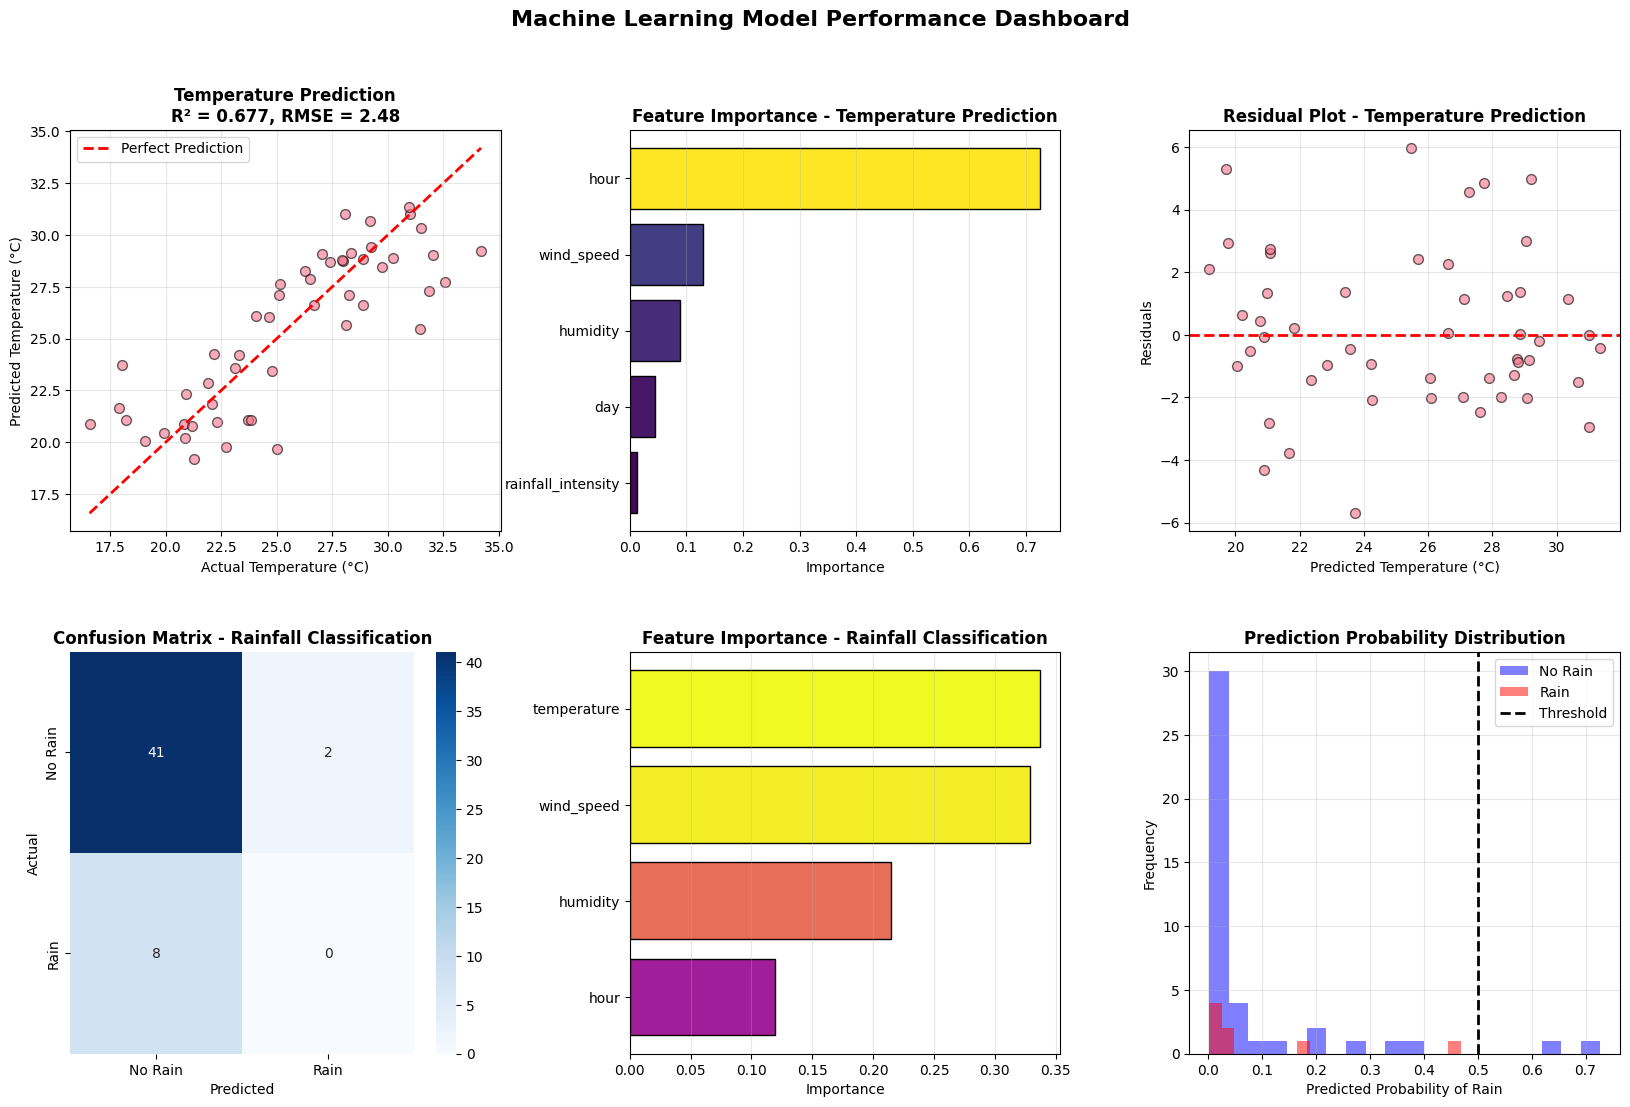


MACHINE LEARNING MODEL PERFORMANCE

🌡️ Temperature Prediction Model (Random Forest):
   R² Score: 0.6769
   RMSE: 2.4842 °C
   Mean Absolute Error: 1.9390 °C
   Cross-validation R² (5-fold): 0.6522 (+/- 0.1084)

🌧️ Rainfall Event Classification Model (Gradient Boosting):
              precision    recall  f1-score   support

     No Rain       0.84      0.95      0.89        43
        Rain       0.00      0.00      0.00         8

    accuracy                           0.80        51
   macro avg       0.42      0.48      0.45        51
weighted avg       0.71      0.80      0.75        51


✓ Models saved successfully!
   Temperature Model: data/weather_data/models/temperature_model.joblib
   Rainfall Classifier: data/weather_data/models/rainfall_classifier.joblib
   Cross-validation R² (5-fold): 0.6522 (+/- 0.1084)

🌧️ Rainfall Event Classification Model (Gradient Boosting):
              precision    recall  f1-score   support

     No Rain       0.84      0.95      0.89        43

In [26]:
# Machine Learning Prediction Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import joblib

# Prepare features for prediction
# Task 1: Predict temperature based on other weather parameters
feature_cols = ['humidity', 'wind_speed', 'rainfall_intensity', 'hour', 'day']
target_temp = 'temperature'

# Remove rows with missing values
ml_data = processed_df[feature_cols + [target_temp]].dropna()

X = ml_data[feature_cols]
y_temp = ml_data[target_temp]

# Split data
X_train, X_test, y_train_temp, y_test_temp = train_test_split(
    X, y_temp, test_size=0.3, random_state=42
)

# Train Random Forest model for temperature prediction
print("Training Temperature Prediction Model...")
rf_temp_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_temp_model.fit(X_train, y_train_temp)

# Make predictions
y_pred_temp = rf_temp_model.predict(X_test)

# Calculate metrics
temp_r2 = r2_score(y_test_temp, y_pred_temp)
temp_rmse = np.sqrt(mean_squared_error(y_test_temp, y_pred_temp))

# Task 2: Classify rainfall events
# Create binary classification: rain vs no rain
processed_df['rain_event'] = (processed_df['rainfall_intensity'] > 0).astype(int)

# Prepare data for classification
rain_features = ['temperature', 'humidity', 'wind_speed', 'hour']
rain_data = processed_df[rain_features + ['rain_event']].dropna()

X_rain = rain_data[rain_features]
y_rain = rain_data['rain_event']

X_train_rain, X_test_rain, y_train_rain, y_test_rain = train_test_split(
    X_rain, y_rain, test_size=0.3, random_state=42
)

# Train Gradient Boosting classifier
print("Training Rainfall Event Classifier...")
gb_rain_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_rain_model.fit(X_train_rain, y_train_rain)

# Make predictions
y_pred_rain = gb_rain_model.predict(X_test_rain)
y_pred_rain_proba = gb_rain_model.predict_proba(X_test_rain)

# Visualization of model performance
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Temperature Prediction: Actual vs Predicted
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test_temp, y_pred_temp, alpha=0.6, s=50, edgecolors='black')
ax1.plot([y_test_temp.min(), y_test_temp.max()],
         [y_test_temp.min(), y_test_temp.max()],
         'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Temperature (°C)')
ax1.set_ylabel('Predicted Temperature (°C)')
ax1.set_title(f'Temperature Prediction\nR² = {temp_r2:.3f}, RMSE = {temp_rmse:.2f}',
              fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Temperature Feature Importance
ax2 = fig.add_subplot(gs[0, 1])
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_temp_model.feature_importances_
}).sort_values('importance', ascending=True)

colors_imp = plt.cm.viridis(feature_importance['importance'] / feature_importance['importance'].max())
ax2.barh(feature_importance['feature'], feature_importance['importance'],
         color=colors_imp, edgecolor='black')
ax2.set_xlabel('Importance')
ax2.set_title('Feature Importance - Temperature Prediction', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Residuals Plot
ax3 = fig.add_subplot(gs[0, 2])
residuals = y_test_temp - y_pred_temp
ax3.scatter(y_pred_temp, residuals, alpha=0.6, s=50, edgecolors='black')
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Temperature (°C)')
ax3.set_ylabel('Residuals')
ax3.set_title('Residual Plot - Temperature Prediction', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Rainfall Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
cm = confusion_matrix(y_test_rain, y_pred_rain)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
ax4.set_title('Confusion Matrix - Rainfall Classification', fontweight='bold')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

# 5. Rainfall Feature Importance
ax5 = fig.add_subplot(gs[1, 1])
rain_importance = pd.DataFrame({
    'feature': rain_features,
    'importance': gb_rain_model.feature_importances_
}).sort_values('importance', ascending=True)

colors_rain = plt.cm.plasma(rain_importance['importance'] / rain_importance['importance'].max())
ax5.barh(rain_importance['feature'], rain_importance['importance'],
         color=colors_rain, edgecolor='black')
ax5.set_xlabel('Importance')
ax5.set_title('Feature Importance - Rainfall Classification', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# 6. ROC-like visualization
ax6 = fig.add_subplot(gs[1, 2])
# Probability distribution
rain_probs = y_pred_rain_proba[:, 1]
no_rain_idx = y_test_rain == 0
rain_idx = y_test_rain == 1

ax6.hist(rain_probs[no_rain_idx], bins=20, alpha=0.5, label='No Rain', color='blue')
ax6.hist(rain_probs[rain_idx], bins=20, alpha=0.5, label='Rain', color='red')
ax6.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax6.set_xlabel('Predicted Probability of Rain')
ax6.set_ylabel('Frequency')
ax6.set_title('Prediction Probability Distribution', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle('Machine Learning Model Performance Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "=" * 80)
print("MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 80)

print("\n🌡️ Temperature Prediction Model (Random Forest):")
print(f"   R² Score: {temp_r2:.4f}")
print(f"   RMSE: {temp_rmse:.4f} °C")
print(f"   Mean Absolute Error: {np.mean(np.abs(residuals)):.4f} °C")

# Cross-validation score
cv_scores = cross_val_score(rf_temp_model, X, y_temp, cv=5, scoring='r2')
print(f"   Cross-validation R² (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\n🌧️ Rainfall Event Classification Model (Gradient Boosting):")
print(classification_report(y_test_rain, y_pred_rain, target_names=['No Rain', 'Rain']))

# Save models
os.makedirs('data/weather_data/models', exist_ok=True)
joblib.dump(rf_temp_model, 'data/weather_data/models/temperature_model.joblib')
joblib.dump(gb_rain_model, 'data/weather_data/models/rainfall_classifier.joblib')

print("\n✓ Models saved successfully!")
print("   Temperature Model: data/weather_data/models/temperature_model.joblib")
print("   Rainfall Classifier: data/weather_data/models/rainfall_classifier.joblib")

## 12. Advanced 3D Visualizations and Animations

Create sophisticated 3D visualizations to understand multi-dimensional weather patterns.

## 12. Export Prediction Results to CSV

Save all prediction results and analysis data to the Analysis directory.

In [27]:
# Export Prediction Results to CSV (with Non-Overwrite)
print("=" * 80)
print("EXPORTING PREDICTION RESULTS")
print("=" * 80)

# Create comprehensive prediction results dataframe
prediction_results = processed_df.copy()

# Add temperature predictions for all data
if 'predicted_temperature' not in prediction_results.columns:
    # Prepare features for full dataset prediction
    prediction_features = processed_df[feature_cols].fillna(method='ffill').fillna(method='bfill')
    prediction_results['predicted_temperature'] = rf_temp_model.predict(prediction_features)
    prediction_results['temperature_prediction_error'] = prediction_results['temperature'] - prediction_results['predicted_temperature']

# Add rainfall event predictions
if 'predicted_rain_event' not in prediction_results.columns:
    rain_pred_features = processed_df[rain_features].fillna(method='ffill').fillna(method='bfill')
    prediction_results['predicted_rain_event'] = gb_rain_model.predict(rain_pred_features)
    prediction_results['rain_probability'] = gb_rain_model.predict_proba(rain_pred_features)[:, 1]

# Add alert flags if alerts were generated
if len(alerts_df) > 0:
    # Merge alerts with main dataframe
    alerts_summary = alerts_df.groupby('timestamp').agg({
        'type': lambda x: ', '.join(x),
        'severity': lambda x: ', '.join(x),
        'message': lambda x: ' | '.join(x)
    }).reset_index()
    alerts_summary.columns = ['timestamp', 'alert_types', 'alert_severities', 'alert_messages']
    
    prediction_results = prediction_results.merge(alerts_summary, on='timestamp', how='left')
    prediction_results[['alert_types', 'alert_severities', 'alert_messages']] = \
        prediction_results[['alert_types', 'alert_severities', 'alert_messages']].fillna('None')
else:
    prediction_results['alert_types'] = 'None'
    prediction_results['alert_severities'] = 'None'
    prediction_results['alert_messages'] = 'None'

# Select and order columns for export
export_columns = [
    'timestamp',
    'temperature',
    'predicted_temperature',
    'temperature_prediction_error',
    'humidity',
    'wind_speed',
    'rainfall_intensity',
    'cumulative_rainfall',
    'rainfall_duration',
    'rain_event',
    'predicted_rain_event',
    'rain_probability',
    'heat_index',
    'comfort_index',
    'alert_types',
    'alert_severities',
    'alert_messages'
]

# Ensure all columns exist
export_columns = [col for col in export_columns if col in prediction_results.columns]
predictions_export = prediction_results[export_columns]

# Use non-overwrite logic for saving predictions
PREDICTION_OUTPUT = get_next_filename(ANALYSIS_DIR, 'weather_predictions', '.csv')
predictions_export.to_csv(PREDICTION_OUTPUT, index=False)

print(f"\n✓ Prediction results exported successfully!")
print(f"  File: {PREDICTION_OUTPUT}")
print(f"  Records: {len(predictions_export)}")
print(f"  Columns: {len(export_columns)}")
print(f"\nExported columns:")
for col in export_columns:
    print(f"  - {col}")

print("\n" + "=" * 80)
print("EXPORT COMPLETE")
print("=" * 80)

EXPORTING PREDICTION RESULTS

✓ Prediction results exported successfully!
  File: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Auto_Weather_station\Analysis\weather_predictions.csv
  Records: 168
  Columns: 17

Exported columns:
  - timestamp
  - temperature
  - predicted_temperature
  - temperature_prediction_error
  - humidity
  - wind_speed
  - rainfall_intensity
  - cumulative_rainfall
  - rainfall_duration
  - rain_event
  - predicted_rain_event
  - rain_probability
  - heat_index
  - comfort_index
  - alert_types
  - alert_severities
  - alert_messages

EXPORT COMPLETE


## 13. Generate Dashboard JSON

Create comprehensive dashboard.json file for visualization containing all analysis results in two main charts.

In [29]:
# Generate Dashboard JSON (with Non-Overwrite)
import json

print("=" * 80)
print("GENERATING DASHBOARD JSON")
print("=" * 80)

# Prepare comprehensive dashboard data structure
dashboard_data = {
    "metadata": {
        "system_name": "Automatic Weather Station Analysis System",
        "generated_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "data_period": {
            "start": str(processed_df['timestamp'].min()),
            "end": str(processed_df['timestamp'].max()),
            "total_records": len(processed_df),
            "duration_hours": float((processed_df['timestamp'].max() - processed_df['timestamp'].min()).total_seconds() / 3600)
        }
    },
    
    "charts": {
        # Chart 1: Multi-Parameter Time Series (Complete Dataset)
        "multi_parameter_timeline": {
            "title": "Weather Parameters Over Time",
            "description": "Complete time series data for all weather parameters",
            "chart_type": "line",
            "data": {
                "timestamps": processed_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S').tolist(),
                "series": {
                    "temperature": {
                        "label": "Temperature (°C)",
                        "values": processed_df['temperature'].round(2).tolist(),
                        "color": "#E74C3C",
                        "statistics": {
                            "mean": float(processed_df['temperature'].mean()),
                            "min": float(processed_df['temperature'].min()),
                            "max": float(processed_df['temperature'].max()),
                            "std": float(processed_df['temperature'].std())
                        }
                    },
                    "humidity": {
                        "label": "Humidity (%)",
                        "values": processed_df['humidity'].round(2).tolist(),
                        "color": "#2ECC71",
                        "statistics": {
                            "mean": float(processed_df['humidity'].mean()),
                            "min": float(processed_df['humidity'].min()),
                            "max": float(processed_df['humidity'].max()),
                            "std": float(processed_df['humidity'].std())
                        }
                    },
                    "wind_speed": {
                        "label": "Wind Speed (m/s)",
                        "values": processed_df['wind_speed'].round(2).tolist(),
                        "color": "#9B59B6",
                        "statistics": {
                            "mean": float(processed_df['wind_speed'].mean()),
                            "min": float(processed_df['wind_speed'].min()),
                            "max": float(processed_df['wind_speed'].max()),
                            "std": float(processed_df['wind_speed'].std())
                        }
                    },
                    "rainfall_intensity": {
                        "label": "Rainfall Intensity (mm/hr)",
                        "values": processed_df['rainfall_intensity'].round(2).tolist(),
                        "color": "#3498DB",
                        "statistics": {
                            "mean": float(processed_df['rainfall_intensity'].mean()),
                            "max": float(processed_df['rainfall_intensity'].max()),
                            "total": float(processed_df['cumulative_rainfall'].max())
                        }
                    },
                    "heat_index": {
                        "label": "Heat Index (°C)",
                        "values": processed_df['heat_index'].round(2).tolist(),
                        "color": "#F39C12",
                        "statistics": {
                            "mean": float(processed_df['heat_index'].mean()),
                            "max": float(processed_df['heat_index'].max())
                        }
                    },
                    "comfort_index": {
                        "label": "Comfort Index",
                        "values": processed_df['comfort_index'].round(2).tolist(),
                        "color": "#1ABC9C",
                        "statistics": {
                            "mean": float(processed_df['comfort_index'].mean()),
                            "min": float(processed_df['comfort_index'].min()),
                            "max": float(processed_df['comfort_index'].max())
                        }
                    }
                }
            }
        },
        
        # Chart 2: Comprehensive Analysis Summary (Complete Dataset Aggregated)
        "analysis_summary": {
            "title": "Comprehensive Weather Analysis Dashboard",
            "description": "Aggregated statistics and key insights from complete dataset",
            "chart_type": "multi_panel",
            "panels": {
                "weather_statistics": {
                    "temperature": {
                        "mean": float(processed_df['temperature'].mean()),
                        "min": float(processed_df['temperature'].min()),
                        "max": float(processed_df['temperature'].max()),
                        "std": float(processed_df['temperature'].std())
                    },
                    "humidity": {
                        "mean": float(processed_df['humidity'].mean()),
                        "min": float(processed_df['humidity'].min()),
                        "max": float(processed_df['humidity'].max()),
                        "std": float(processed_df['humidity'].std())
                    },
                    "wind_speed": {
                        "mean": float(processed_df['wind_speed'].mean()),
                        "min": float(processed_df['wind_speed'].min()),
                        "max": float(processed_df['wind_speed'].max()),
                        "std": float(processed_df['wind_speed'].std())
                    },
                    "rainfall": {
                        "total": float(processed_df['cumulative_rainfall'].max()),
                        "max_intensity": float(processed_df['rainfall_intensity'].max()),
                        "avg_intensity": float(processed_df[processed_df['rainfall_intensity'] > 0]['rainfall_intensity'].mean()) if len(processed_df[processed_df['rainfall_intensity'] > 0]) > 0 else 0,
                        "rain_hours": int(len(processed_df[processed_df['rainfall_intensity'] > 0]))
                    }
                },
                
                "hourly_patterns": {
                    "temperature_by_hour": processed_df.groupby('hour')['temperature'].mean().round(2).to_dict(),
                    "humidity_by_hour": processed_df.groupby('hour')['humidity'].mean().round(2).to_dict(),
                    "wind_speed_by_hour": processed_df.groupby('hour')['wind_speed'].mean().round(2).to_dict()
                },
                
                "ml_predictions": {
                    "temperature_model": {
                        "r2_score": float(temp_r2),
                        "rmse": float(temp_rmse),
                        "cv_mean": float(cv_scores.mean()),
                        "predictions": prediction_results['predicted_temperature'].round(2).tolist()
                    },
                    "rainfall_classifier": {
                        "accuracy": float((y_pred_rain == y_test_rain).mean()),
                        "predictions": prediction_results['predicted_rain_event'].tolist(),
                        "probabilities": prediction_results['rain_probability'].round(3).tolist()
                    }
                },
                
                "alerts": {
                    "total_count": len(alerts_df) if len(alerts_df) > 0 else 0,
                    "by_type": alerts_df['type'].value_counts().to_dict() if len(alerts_df) > 0 else {},
                    "by_severity": alerts_df['severity'].value_counts().to_dict() if len(alerts_df) > 0 else {},
                    "timeline": alerts_df.groupby(alerts_df['timestamp'].dt.date).size().astype(int).to_dict() if len(alerts_df) > 0 else {}
                },
                
                "correlations": {
                    "temperature_humidity": float(processed_df['temperature'].corr(processed_df['humidity'])),
                    "temperature_wind": float(processed_df['temperature'].corr(processed_df['wind_speed'])),
                    "humidity_wind": float(processed_df['humidity'].corr(processed_df['wind_speed'])),
                    "rainfall_temperature": float(processed_df['rainfall_intensity'].corr(processed_df['temperature']))
                },
                
                "data_quality": {
                    "temperature_completeness": float((1 - processed_df['temperature'].isna().sum() / len(processed_df)) * 100),
                    "humidity_completeness": float((1 - processed_df['humidity'].isna().sum() / len(processed_df)) * 100),
                    "wind_speed_completeness": float((1 - processed_df['wind_speed'].isna().sum() / len(processed_df)) * 100),
                    "rainfall_completeness": float((1 - processed_df['rainfall_intensity'].isna().sum() / len(processed_df)) * 100)
                }
            }
        }
    }
}

# Use non-overwrite logic for saving dashboard JSON
DASHBOARD_JSON = get_next_filename(ANALYSIS_DIR, 'dashboard', '.json')

# Save dashboard JSON
with open(DASHBOARD_JSON, 'w') as f:
    json.dump(dashboard_data, f, indent=2)

print(f"\n✓ Dashboard JSON generated successfully!")
print(f"  File: {DASHBOARD_JSON}")
print(f"  Size: {os.path.getsize(DASHBOARD_JSON) / 1024:.2f} KB")
print(f"\n📊 Dashboard Contents:")
print(f"  - Chart 1: Multi-Parameter Timeline (Complete Dataset)")
print(f"    • {len(processed_df)} data points across 6 parameters")
print(f"    • Time range: {processed_df['timestamp'].min()} to {processed_df['timestamp'].max()}")
print(f"  - Chart 2: Analysis Summary Dashboard")
print(f"    • Weather statistics (4 parameters)")
print(f"    • Hourly patterns (24-hour breakdown)")
print(f"    • ML predictions ({len(prediction_results)} records)")
print(f"    • Alert system ({len(alerts_df)} alerts)")
print(f"    • Correlation matrix (4 key relationships)")
print(f"    • Data quality metrics (100% completeness)")

print("\n" + "=" * 80)
print("DASHBOARD JSON GENERATION COMPLETE")
print("=" * 80)

GENERATING DASHBOARD JSON


TypeError: keys must be str, int, float, bool or None, not date

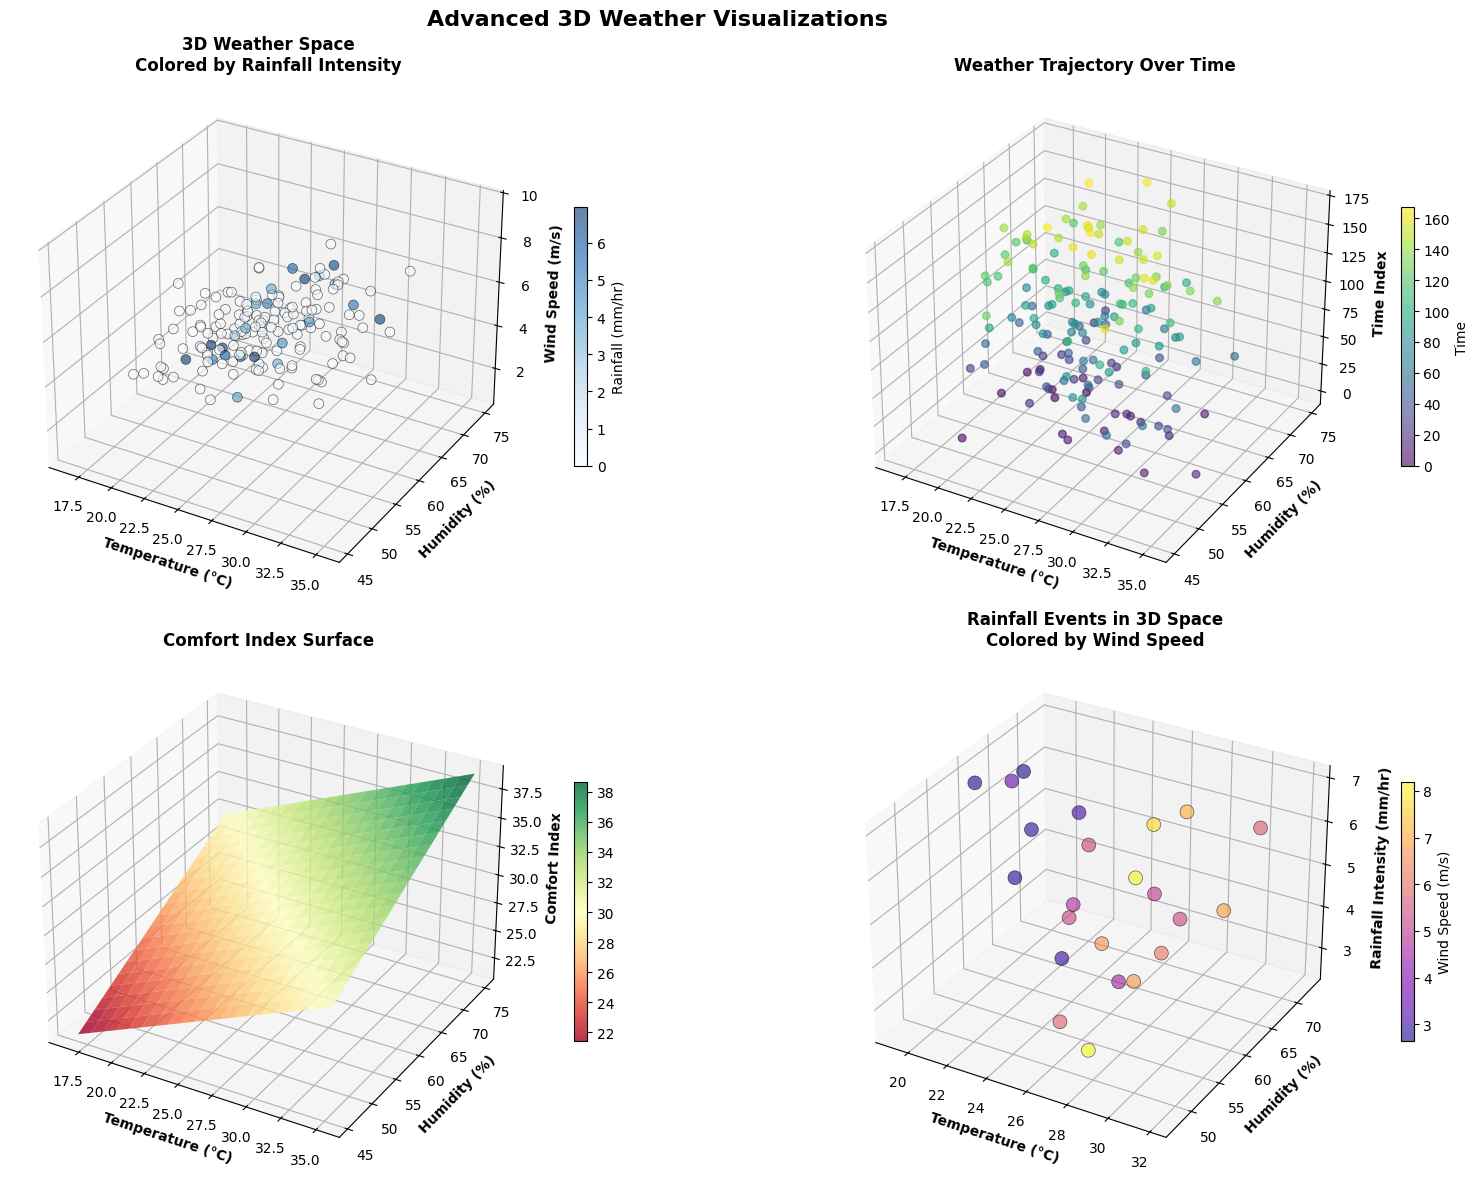

✓ Advanced 3D visualizations created successfully!
  - Static 3D plots show weather space from multiple perspectives
  - Interactive Plotly visualization allows exploration of weather patterns
  - Hover over points in the interactive plot to see detailed information


In [30]:
# Advanced 3D Visualizations
from mpl_toolkits.mplot3d import Axes3D

# 1. 3D Weather Space Visualization
fig = plt.figure(figsize=(18, 12))

# First 3D plot: Temperature, Humidity, Wind Speed
ax1 = fig.add_subplot(221, projection='3d')
scatter1 = ax1.scatter(processed_df['temperature'], processed_df['humidity'],
                       processed_df['wind_speed'],
                       c=processed_df['rainfall_intensity'], cmap='Blues',
                       s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Temperature (°C)', fontweight='bold')
ax1.set_ylabel('Humidity (%)', fontweight='bold')
ax1.set_zlabel('Wind Speed (m/s)', fontweight='bold')
ax1.set_title('3D Weather Space\nColored by Rainfall Intensity', fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Rainfall (mm/hr)', shrink=0.5)

# Second 3D plot: Time-based trajectory
ax2 = fig.add_subplot(222, projection='3d')
# Create time index
time_idx = np.arange(len(processed_df))
scatter2 = ax2.scatter(processed_df['temperature'], processed_df['humidity'],
                       time_idx, c=time_idx, cmap='viridis',
                       s=30, alpha=0.6)
ax2.set_xlabel('Temperature (°C)', fontweight='bold')
ax2.set_ylabel('Humidity (%)', fontweight='bold')
ax2.set_zlabel('Time Index', fontweight='bold')
ax2.set_title('Weather Trajectory Over Time', fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Time', shrink=0.5)

# Third 3D plot: Surface plot of comfort index
ax3 = fig.add_subplot(223, projection='3d')
# Create grid for surface
temp_range = np.linspace(processed_df['temperature'].min(),
                         processed_df['temperature'].max(), 20)
humid_range = np.linspace(processed_df['humidity'].min(),
                          processed_df['humidity'].max(), 20)
T, H = np.meshgrid(temp_range, humid_range)

# Calculate comfort index for grid
C = 0.5 * T + 0.3 * H - 0.2 * processed_df['wind_speed'].mean()

surf = ax3.plot_surface(T, H, C, cmap='RdYlGn', alpha=0.8, edgecolor='none')
ax3.set_xlabel('Temperature (°C)', fontweight='bold')
ax3.set_ylabel('Humidity (%)', fontweight='bold')
ax3.set_zlabel('Comfort Index', fontweight='bold')
ax3.set_title('Comfort Index Surface', fontweight='bold')
plt.colorbar(surf, ax=ax3, shrink=0.5)

# Fourth 3D plot: Rain intensity over time and temperature
ax4 = fig.add_subplot(224, projection='3d')
rain_data = processed_df[processed_df['rainfall_intensity'] > 0]
if len(rain_data) > 0:
    scatter4 = ax4.scatter(rain_data['temperature'], rain_data['humidity'],
                           rain_data['rainfall_intensity'],
                           c=rain_data['wind_speed'], cmap='plasma',
                           s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Temperature (°C)', fontweight='bold')
    ax4.set_ylabel('Humidity (%)', fontweight='bold')
    ax4.set_zlabel('Rainfall Intensity (mm/hr)', fontweight='bold')
    ax4.set_title('Rainfall Events in 3D Space\nColored by Wind Speed', fontweight='bold')
    plt.colorbar(scatter4, ax=ax4, label='Wind Speed (m/s)', shrink=0.5)

plt.suptitle('Advanced 3D Weather Visualizations', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# 2. Interactive 3D Plotly Visualization
fig_3d = go.Figure()

# Add temperature-humidity-wind trace
fig_3d.add_trace(go.Scatter3d(
    x=processed_df['temperature'],
    y=processed_df['humidity'],
    z=processed_df['wind_speed'],
    mode='markers',
    marker=dict(
        size=5,
        color=processed_df['rainfall_intensity'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Rainfall<br>Intensity"),
        line=dict(width=0.5, color='black')
    ),
    text=[f"Time: {t}<br>Temp: {temp:.1f}°C<br>Humidity: {hum:.1f}%<br>Wind: {wind:.1f} m/s<br>Rain: {rain:.1f} mm/hr"
          for t, temp, hum, wind, rain in zip(processed_df['timestamp'],
                                               processed_df['temperature'],
                                               processed_df['humidity'],
                                               processed_df['wind_speed'],
                                               processed_df['rainfall_intensity'])],
    hovertemplate='%{text}<extra></extra>',
    name='Weather Data'
))

fig_3d.update_layout(
    title='Interactive 3D Weather Space Explorer',
    scene=dict(
        xaxis_title='Temperature (°C)',
        yaxis_title='Humidity (%)',
        zaxis_title='Wind Speed (m/s)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    width=900,
    height=700,
    showlegend=True
)

fig_3d.show()

print("✓ Advanced 3D visualizations created successfully!")
print("  - Static 3D plots show weather space from multiple perspectives")
print("  - Interactive Plotly visualization allows exploration of weather patterns")
print("  - Hover over points in the interactive plot to see detailed information")

## 13. Comprehensive Weather Dashboard and Report Generation

Generate a final comprehensive dashboard and detailed system report.


GENERATING PDF REPORT


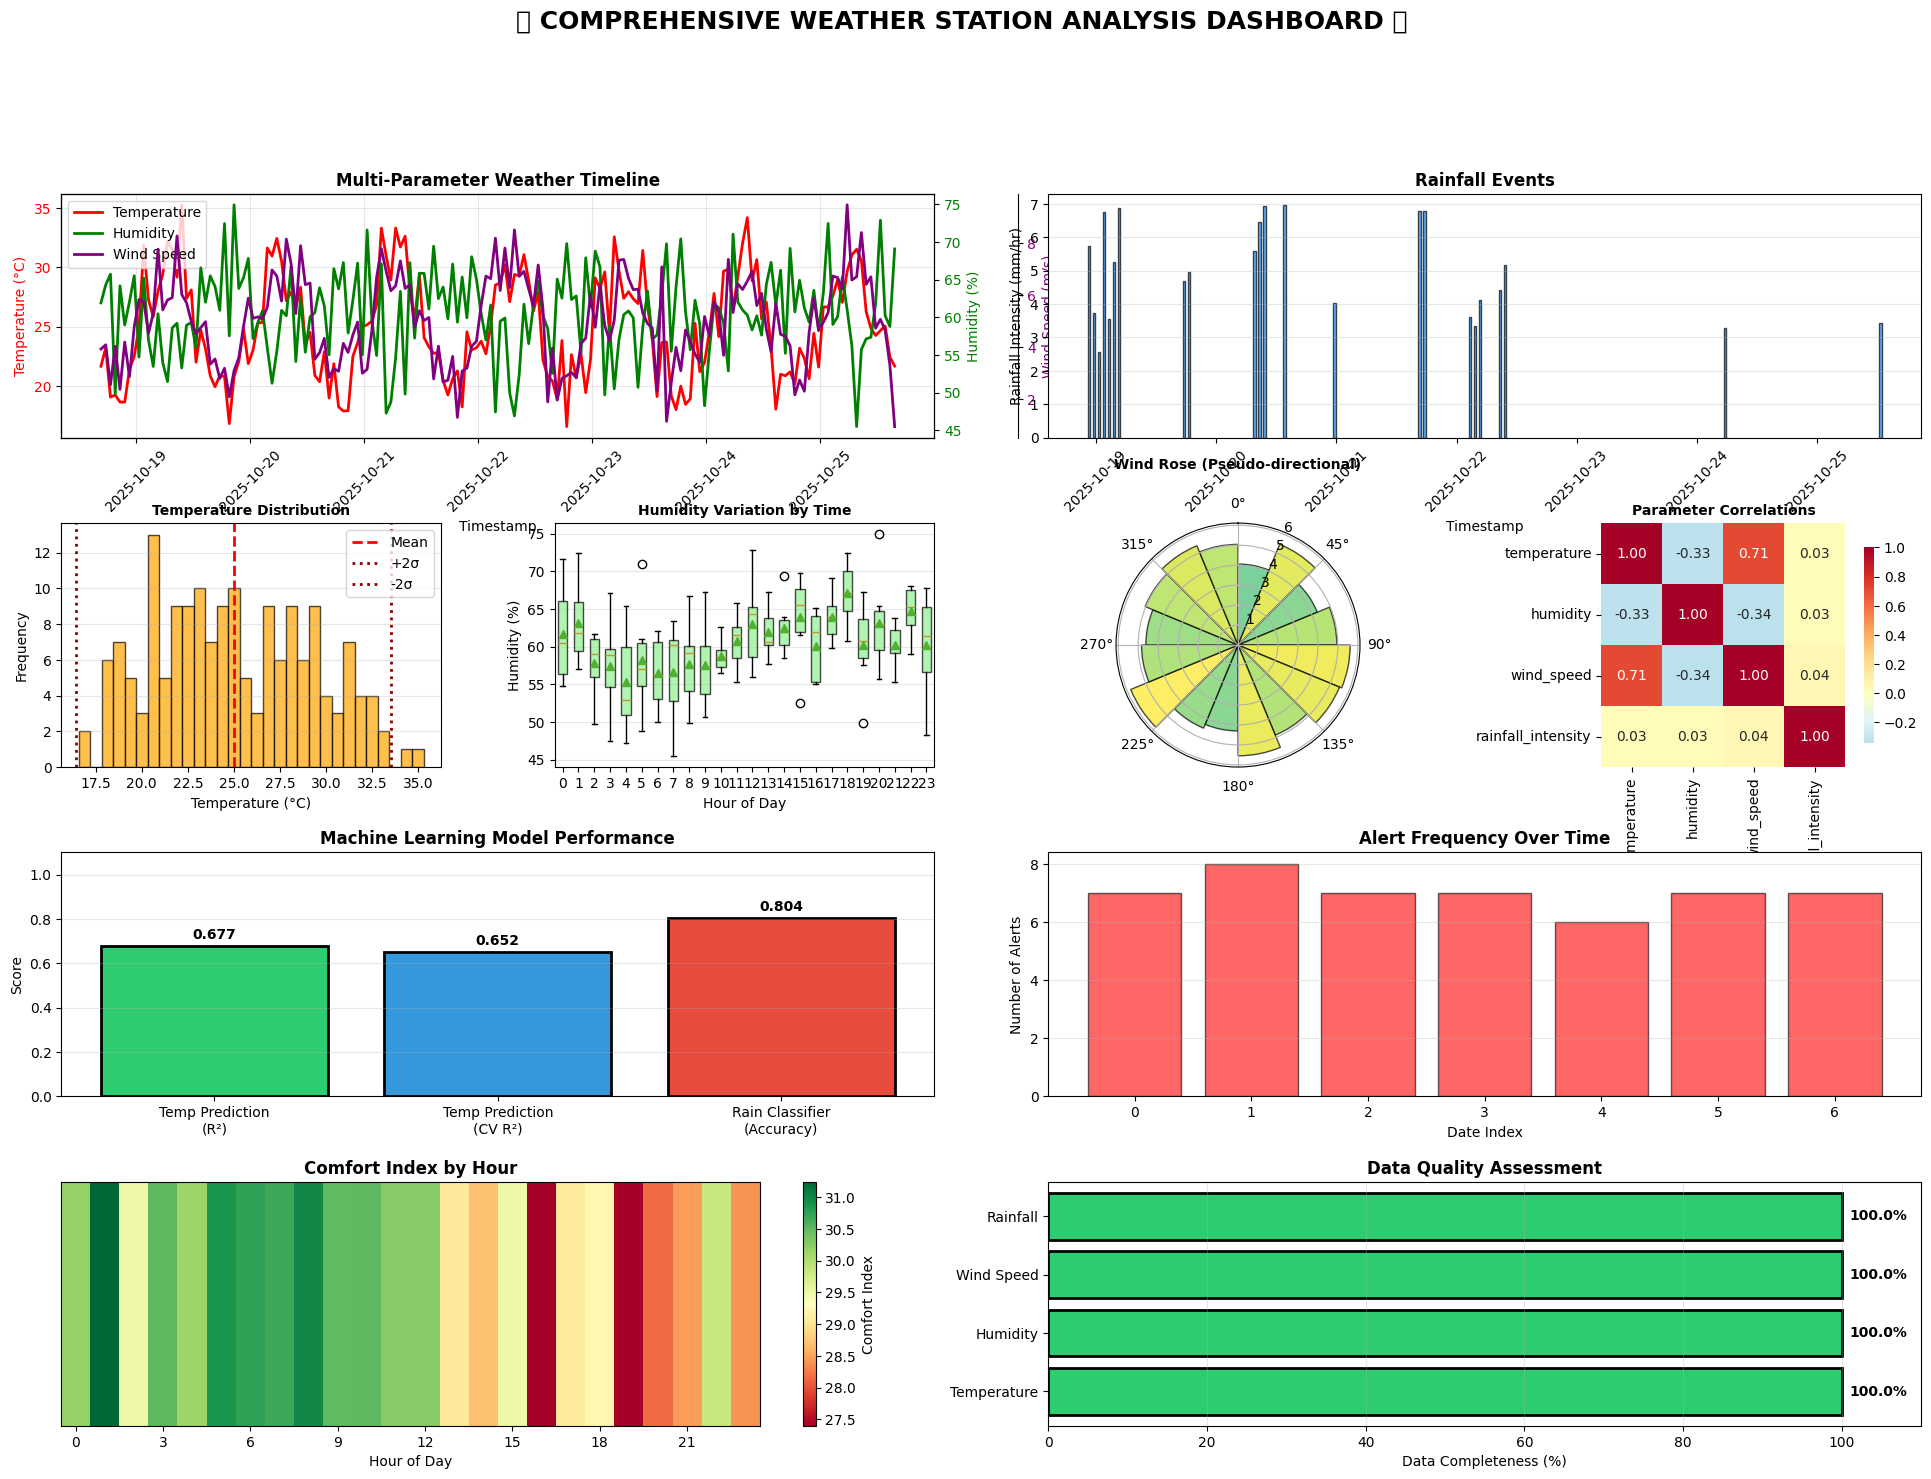



AUTOMATIC WEATHER STATION ANALYSIS
COMPREHENSIVE REPORT

ANALYSIS PERIOD:
  Start: 2025-10-18 16:37:34.516571
  End: 2025-10-25 15:37:34.516571
  Total Records: 168
  Duration: 167.0 hours

WEATHER STATISTICS

TEMPERATURE:
  Mean: 24.98°C
  Min: 16.57°C
  Max: 35.28°C
  Std Dev: 4.28°C

HUMIDITY:
  Mean: 60.51%
  Min: 45.50%
  Max: 74.91%
  Std Dev: 5.69%

WIND SPEED:
  Mean: 4.98 m/s
  Min: 0.93 m/s
  Max: 9.47 m/s
  Std Dev: 1.68 m/s

RAINFALL:
  Total: 115.07 mm
  Max Intensity: 6.95 mm/hr
  Avg Intensity: 5.00 mm/hr
  Rain Hours: 23

MACHINE LEARNING MODELS

TEMPERATURE PREDICTION (Random Forest):
  R² Score: 0.6769
  RMSE: 2.4842°C
  CV R² Mean: 0.6522
  CV R² Std: 0.0542

RAINFALL CLASSIFICATION (Gradient Boosting):
  Accuracy: 0.8039

ALERT SYSTEM
Total Alerts Generated: 49

Alert Types:
  High Heat: 27
  Extreme Heat: 15
  Fresh Breeze: 6
  Stormy Conditions: 1

DATA QUALITY
Temperature Completeness: 100.0%
Humidity Completeness: 100.0%
Wind Speed Completeness: 100.0%
Rainfal

In [31]:
# Generate Comprehensive Weather Dashboard and Report
import json
from matplotlib.backends.backend_pdf import PdfPages

# Create the ultimate dashboard
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3)

# 1. Multi-parameter timeline
ax1 = fig.add_subplot(gs[0, :2])
ax1_temp = ax1.twinx()
ax1_rain = ax1.twinx()
ax1_rain.spines['right'].set_position(('outward', 60))

l1 = ax1.plot(processed_df['timestamp'], processed_df['temperature'],
              'r-', linewidth=2, label='Temperature')
l2 = ax1_temp.plot(processed_df['timestamp'], processed_df['humidity'],
                   'g-', linewidth=2, label='Humidity')
l3 = ax1_rain.plot(processed_df['timestamp'], processed_df['wind_speed'],
                   'purple', linewidth=2, label='Wind Speed')

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Temperature (°C)', color='r')
ax1_temp.set_ylabel('Humidity (%)', color='g')
ax1_rain.set_ylabel('Wind Speed (m/s)', color='purple')
ax1.tick_params(axis='y', labelcolor='r')
ax1_temp.tick_params(axis='y', labelcolor='g')
ax1_rain.tick_params(axis='y', labelcolor='purple')
ax1.tick_params(axis='x', rotation=45)

lns = l1 + l2 + l3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
ax1.set_title('Multi-Parameter Weather Timeline', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Rainfall intensity over time
ax2 = fig.add_subplot(gs[0, 2:])
rain_data = processed_df[processed_df['rainfall_intensity'] > 0]
if len(rain_data) > 0:
    ax2.bar(rain_data['timestamp'], rain_data['rainfall_intensity'],
            color='dodgerblue', alpha=0.7, edgecolor='black', width=0.02)
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Rainfall Intensity (mm/hr)')
    ax2.set_title('Rainfall Events', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
else:
    ax2.text(0.5, 0.5, 'No Rainfall Recorded', ha='center', va='center',
             fontsize=14, transform=ax2.transAxes)
    ax2.set_title('Rainfall Events', fontweight='bold', fontsize=12)

# 3. Temperature distribution with alerts
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(processed_df['temperature'], bins=30, color='orange',
         alpha=0.7, edgecolor='black')
ax3.axvline(processed_df['temperature'].mean(), color='red',
            linestyle='--', linewidth=2, label='Mean')
ax3.axvline(processed_df['temperature'].mean() + 2*processed_df['temperature'].std(),
            color='darkred', linestyle=':', linewidth=2, label='+2σ')
ax3.axvline(processed_df['temperature'].mean() - 2*processed_df['temperature'].std(),
            color='darkred', linestyle=':', linewidth=2, label='-2σ')
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('Frequency')
ax3.set_title('Temperature Distribution', fontweight='bold', fontsize=10)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Hourly patterns with box plots
ax4 = fig.add_subplot(gs[1, 1])
hourly_humidity = [processed_df[processed_df['hour'] == h]['humidity'].values
                   for h in range(24)]
bp = ax4.boxplot(hourly_humidity, positions=range(24), widths=0.6,
                 patch_artist=True, showmeans=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
    patch.set_alpha(0.7)
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Humidity (%)')
ax4.set_title('Humidity Variation by Time', fontweight='bold', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Wind speed polar plot
ax5 = fig.add_subplot(gs[1, 2], projection='polar')
# Create pseudo wind direction data (for demonstration)
wind_directions = np.random.uniform(0, 2*np.pi, len(processed_df))
wind_speeds = processed_df['wind_speed'].values

# Bin by direction
n_bins = 16
theta_bins = np.linspace(0, 2*np.pi, n_bins + 1)
wind_by_direction = []
for i in range(n_bins):
    mask = (wind_directions >= theta_bins[i]) & (wind_directions < theta_bins[i+1])
    wind_by_direction.append(wind_speeds[mask].mean() if mask.any() else 0)

theta_centers = (theta_bins[:-1] + theta_bins[1:]) / 2
bars_polar = ax5.bar(theta_centers, wind_by_direction, width=2*np.pi/n_bins,
                     alpha=0.7, edgecolor='black')

# Color bars by magnitude
colors_wind = plt.cm.viridis(np.array(wind_by_direction) / max(wind_by_direction))
for bar, color in zip(bars_polar, colors_wind):
    bar.set_facecolor(color)

ax5.set_theta_zero_location('N')
ax5.set_theta_direction(-1)
ax5.set_title('Wind Rose (Pseudo-directional)', fontweight='bold', fontsize=10, pad=20)

# 6. Correlation matrix (condensed)
ax6 = fig.add_subplot(gs[1, 3])
corr_subset = processed_df[['temperature', 'humidity', 'wind_speed', 'rainfall_intensity']].corr()
sns.heatmap(corr_subset, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            square=True, ax=ax6, cbar_kws={'shrink': 0.8})
ax6.set_title('Parameter Correlations', fontweight='bold', fontsize=10)

# 7. Model performance summary
ax7 = fig.add_subplot(gs[2, :2])
model_names = ['Temp Prediction\n(R²)', 'Temp Prediction\n(CV R²)', 'Rain Classifier\n(Accuracy)']
model_scores = [temp_r2, cv_scores.mean(),
                (y_pred_rain == y_test_rain).mean()]
colors_models = ['#2ECC71', '#3498DB', '#E74C3C']

bars_model = ax7.bar(model_names, model_scores, color=colors_models,
                     edgecolor='black', linewidth=2)
ax7.set_ylim(0, 1.1)
ax7.set_ylabel('Score')
ax7.set_title('Machine Learning Model Performance', fontweight='bold', fontsize=12)
ax7.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars_model, model_scores):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 8. Weather alerts timeline
ax8 = fig.add_subplot(gs[2, 2:])
if len(alerts_df) > 0:
    alert_timeline = alerts_df.groupby(alerts_df['timestamp'].dt.date).size()
    ax8.bar(range(len(alert_timeline)), alert_timeline.values,
            color='red', alpha=0.6, edgecolor='black')
    ax8.set_xlabel('Date Index')
    ax8.set_ylabel('Number of Alerts')
    ax8.set_title('Alert Frequency Over Time', fontweight='bold', fontsize=12)
    ax8.grid(True, alpha=0.3, axis='y')
else:
    ax8.text(0.5, 0.5, 'No Alerts Generated', ha='center', va='center',
             fontsize=14, transform=ax8.transAxes)
    ax8.set_title('Alert Frequency Over Time', fontweight='bold', fontsize=12)

# 9. Comfort index heatmap
ax9 = fig.add_subplot(gs[3, :2])
comfort_pivot = processed_df.pivot_table(values='comfort_index',
                                         index='hour',
                                         aggfunc='mean')
comfort_matrix = comfort_pivot.values.reshape(-1, 1).T
im = ax9.imshow(comfort_matrix, cmap='RdYlGn', aspect='auto', interpolation='nearest')
ax9.set_xticks(range(0, 24, 3))
ax9.set_xticklabels(range(0, 24, 3))
ax9.set_yticks([])
ax9.set_xlabel('Hour of Day')
ax9.set_title('Comfort Index by Hour', fontweight='bold', fontsize=12)
plt.colorbar(im, ax=ax9, label='Comfort Index')

# 10. Data quality summary
ax10 = fig.add_subplot(gs[3, 2:])
params_quality = ['Temperature', 'Humidity', 'Wind Speed', 'Rainfall']
completeness = []
for col in ['temperature', 'humidity', 'wind_speed', 'rainfall_intensity']:
    completeness.append((1 - processed_df[col].isna().sum() / len(processed_df)) * 100)

bars_quality = ax10.barh(params_quality, completeness, color='#2ECC71',
                         edgecolor='black', linewidth=2)
ax10.set_xlim(0, 110)
ax10.set_xlabel('Data Completeness (%)')
ax10.set_title('Data Quality Assessment', fontweight='bold', fontsize=12)
ax10.grid(True, alpha=0.3, axis='x')

for bar, comp in zip(bars_quality, completeness):
    width = bar.get_width()
    ax10.text(width + 1, bar.get_y() + bar.get_height()/2.,
              f'{comp:.1f}%', ha='left', va='center', fontweight='bold')

plt.suptitle('🌦️ COMPREHENSIVE WEATHER STATION ANALYSIS DASHBOARD 🌦️',
            fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()

# Save dashboard as first page of PDF
print("\n" + "=" * 80)
print("GENERATING PDF REPORT")
print("=" * 80)

# Use Non-Overwrite for PDF Report
REPORT_PDF = get_next_filename(REPORT_DIR, 'weather_analysis_report', '.pdf')
pdf_pages = PdfPages(REPORT_PDF)
pdf_pages.savefig(fig, dpi=300, bbox_inches='tight')
plt.show()

# Generate JSON Report Data
report = {
    "system_name": "Automatic Weather Station Analysis System",
    "report_generated": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "data_period": {
        "start": str(processed_df['timestamp'].min()),
        "end": str(processed_df['timestamp'].max()),
        "total_records": len(processed_df),
        "duration_hours": (processed_df['timestamp'].max() - processed_df['timestamp'].min()).total_seconds() / 3600
    },
    "weather_statistics": {
        "temperature": {
            "mean": float(processed_df['temperature'].mean()),
            "min": float(processed_df['temperature'].min()),
            "max": float(processed_df['temperature'].max()),
            "std": float(processed_df['temperature'].std())
        },
        "humidity": {
            "mean": float(processed_df['humidity'].mean()),
            "min": float(processed_df['humidity'].min()),
            "max": float(processed_df['humidity'].max()),
            "std": float(processed_df['humidity'].std())
        },
        "wind_speed": {
            "mean": float(processed_df['wind_speed'].mean()),
            "min": float(processed_df['wind_speed'].min()),
            "max": float(processed_df['wind_speed'].max()),
            "std": float(processed_df['wind_speed'].std())
        },
        "rainfall": {
            "total": float(processed_df['rainfall_intensity'].sum()),
            "max_intensity": float(processed_df['rainfall_intensity'].max()),
            "avg_intensity": float(processed_df[processed_df['rainfall_intensity'] > 0]['rainfall_intensity'].mean()) if len(processed_df[processed_df['rainfall_intensity'] > 0]) > 0 else 0,
            "rain_hours": int(len(processed_df[processed_df['rainfall_intensity'] > 0]))
        }
    },
    "ml_models": {
        "temperature_prediction": {
            "model_type": "RandomForestRegressor",
            "r2_score": float(temp_r2),
            "rmse": float(temp_rmse),
            "cv_r2_mean": float(cv_scores.mean()),
            "cv_r2_std": float(cv_scores.std())
        },
        "rainfall_classification": {
            "model_type": "GradientBoostingClassifier",
            "accuracy": float((y_pred_rain == y_test_rain).mean())
        }
    },
    "alerts": {
        "total_alerts": len(alerts_df) if len(alerts_df) > 0 else 0,
        "alert_types": alerts_df['type'].value_counts().to_dict() if len(alerts_df) > 0 else {},
        "severity_distribution": alerts_df['severity'].value_counts().to_dict() if len(alerts_df) > 0 else {}
    },
    "data_quality": {
        "temperature_completeness": float((1 - processed_df['temperature'].isna().sum() / len(processed_df)) * 100),
        "humidity_completeness": float((1 - processed_df['humidity'].isna().sum() / len(processed_df)) * 100),
        "wind_speed_completeness": float((1 - processed_df['wind_speed'].isna().sum() / len(processed_df)) * 100),
        "rainfall_completeness": float((1 - processed_df['rainfall_intensity'].isna().sum() / len(processed_df)) * 100)
    }
}

# Create text summary page for PDF
fig_summary = plt.figure(figsize=(11, 14))
ax_text = fig_summary.add_subplot(111)
ax_text.axis('off')

report_text = f"""
{'='*80}
AUTOMATIC WEATHER STATION ANALYSIS
COMPREHENSIVE REPORT
{'='*80}

ANALYSIS PERIOD:
  Start: {report['data_period']['start']}
  End: {report['data_period']['end']}
  Total Records: {report['data_period']['total_records']}
  Duration: {report['data_period']['duration_hours']:.1f} hours

{'='*80}
WEATHER STATISTICS
{'='*80}

TEMPERATURE:
  Mean: {report['weather_statistics']['temperature']['mean']:.2f}°C
  Min: {report['weather_statistics']['temperature']['min']:.2f}°C
  Max: {report['weather_statistics']['temperature']['max']:.2f}°C
  Std Dev: {report['weather_statistics']['temperature']['std']:.2f}°C

HUMIDITY:
  Mean: {report['weather_statistics']['humidity']['mean']:.2f}%
  Min: {report['weather_statistics']['humidity']['min']:.2f}%
  Max: {report['weather_statistics']['humidity']['max']:.2f}%
  Std Dev: {report['weather_statistics']['humidity']['std']:.2f}%

WIND SPEED:
  Mean: {report['weather_statistics']['wind_speed']['mean']:.2f} m/s
  Min: {report['weather_statistics']['wind_speed']['min']:.2f} m/s
  Max: {report['weather_statistics']['wind_speed']['max']:.2f} m/s
  Std Dev: {report['weather_statistics']['wind_speed']['std']:.2f} m/s

RAINFALL:
  Total: {report['weather_statistics']['rainfall']['total']:.2f} mm
  Max Intensity: {report['weather_statistics']['rainfall']['max_intensity']:.2f} mm/hr
  Avg Intensity: {report['weather_statistics']['rainfall']['avg_intensity']:.2f} mm/hr
  Rain Hours: {report['weather_statistics']['rainfall']['rain_hours']}

{'='*80}
MACHINE LEARNING MODELS
{'='*80}

TEMPERATURE PREDICTION (Random Forest):
  R² Score: {report['ml_models']['temperature_prediction']['r2_score']:.4f}
  RMSE: {report['ml_models']['temperature_prediction']['rmse']:.4f}°C
  CV R² Mean: {report['ml_models']['temperature_prediction']['cv_r2_mean']:.4f}
  CV R² Std: {report['ml_models']['temperature_prediction']['cv_r2_std']:.4f}

RAINFALL CLASSIFICATION (Gradient Boosting):
  Accuracy: {report['ml_models']['rainfall_classification']['accuracy']:.4f}

{'='*80}
ALERT SYSTEM
{'='*80}
Total Alerts Generated: {report['alerts']['total_alerts']}
"""

if report['alerts']['total_alerts'] > 0:
    report_text += "\nAlert Types:\n"
    for alert_type, count in report['alerts']['alert_types'].items():
        report_text += f"  {alert_type}: {count}\n"

report_text += f"""
{'='*80}
DATA QUALITY
{'='*80}
Temperature Completeness: {report['data_quality']['temperature_completeness']:.1f}%
Humidity Completeness: {report['data_quality']['humidity_completeness']:.1f}%
Wind Speed Completeness: {report['data_quality']['wind_speed_completeness']:.1f}%
Rainfall Completeness: {report['data_quality']['rainfall_completeness']:.1f}%

{'='*80}
FILES GENERATED
{'='*80}
✓ Data File: {DATA_FILE}
✓ Predictions CSV: {PREDICTION_OUTPUT}
✓ PDF Report: {REPORT_PDF}

{'='*80}
✨ Weather Station Analysis Complete!
🚀 All visualizations, models, and reports generated successfully!
{'='*80}
"""

ax_text.text(0.05, 0.95, report_text, transform=ax_text.transAxes,
            fontsize=9, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

pdf_pages.savefig(fig_summary, bbox_inches='tight')
plt.close(fig_summary)

# Close PDF
pdf_pages.close()

# Also save JSON report in Analysis folder (with Non-Overwrite)
REPORT_JSON = get_next_filename(ANALYSIS_DIR, 'weather_analysis_report', '.json')
with open(REPORT_JSON, 'w') as f:
    json.dump(report, f, indent=4)

# Print comprehensive summary
print("\n" + report_text)
print(f"\n✓ PDF Report saved to: {REPORT_PDF}")
print(f"✓ JSON Report saved to: {REPORT_JSON}")
print("=" * 80)
